In [2]:
import nltk
from nltk import FreqDist
#nltk.download('stopwords') # run this one time

In [3]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

D:\Tools\Anaconda\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [4]:
#df = pd.read_json('meta_AMAZON_FASHION.json', lines=True)
review = pd.read_json('AMAZON_FASHION.json', lines=True)

In [5]:
review.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,My New 'Friends' !!,1408924800,NaN,NaN,NaN


In [6]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883636 entries, 0 to 883635
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         883636 non-null  int64  
 1   verified        883636 non-null  bool   
 2   reviewTime      883636 non-null  object 
 3   reviewerID      883636 non-null  object 
 4   asin            883636 non-null  object 
 5   reviewerName    883544 non-null  object 
 6   reviewText      882403 non-null  object 
 7   summary         883103 non-null  object 
 8   unixReviewTime  883636 non-null  int64  
 9   vote            79900 non-null   float64
 10  style           304569 non-null  object 
 11  image           28807 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 75.0+ MB


In [7]:
review = review.dropna(subset=["reviewText"])

In [8]:
review = review.dropna(subset=["summary"])

In [9]:
review.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,My New 'Friends' !!,1408924800,NaN,NaN,NaN


### Data Preprocessing

In [10]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

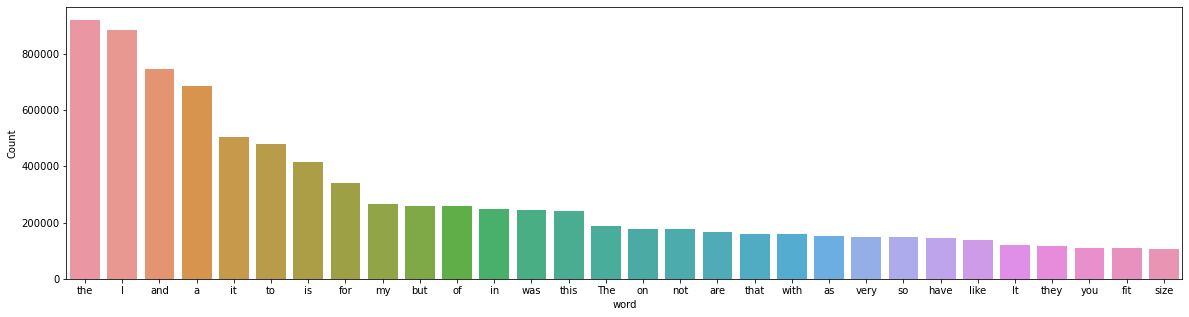

In [11]:
freq_words(review['reviewText'])

In [12]:
df = review['reviewText'].to_frame()
#df[['reviewText']]

In [13]:
#remove stop words as evidenced from previous diagram

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to C:\Users\Arthur
[nltk_data]     Wen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [15]:
stop = set(stopwords.words('english'))

In [16]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, ' ', text).replace("\n", " ").replace("&", " ")

df['noHTML'] = df['reviewText'].apply(remove_html_tags)

In [17]:
df['noStopword'] = df['noHTML'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

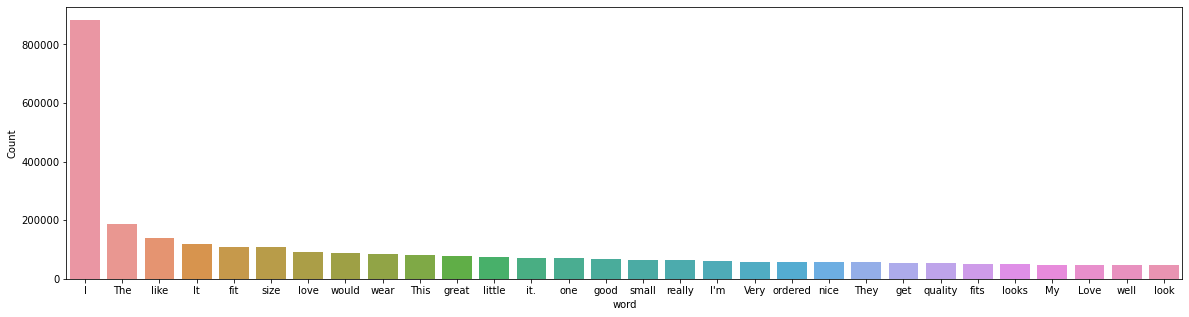

In [18]:
freq_words(df['noStopword'])

In [19]:
df['noStopword'] = df['noStopword'].str.replace("[^a-zA-Z#]", " ")
df['noStopword'] = df['noStopword'].str.lower()

In [20]:
df['tokenized'] = df['noStopword'].apply(nltk.word_tokenize)

In [21]:
df['tagged'] = df['tokenized'].apply(nltk.pos_tag)

In [22]:
df['nouns'] = df['tagged'].apply(lambda x: [word for word, tag in x if tag in ['NN', 'NNS', 'NNP', 'NNPS']])

In [23]:
df['verbs'] = df['tagged'].apply(lambda x: [word for word, tag in x if tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']])

In [24]:
df['adjs'] = df['tagged'].apply(lambda x: [word for word, tag in x if tag.startswith("J")])

In [25]:
df['adverbs'] = df['tagged'].apply(lambda x: [word for word, tag in x if tag.startswith("RB")])

In [26]:
df.head()

,reviewText,noHTML,noStopword,tokenized,tagged,nouns,verbs,adjs,adverbs
0,Exactly what I needed.,Exactly what I needed.,exactly i needed,"[exactly, i, needed]","[(exactly, RB), (i, NN), (needed, VBD)]",[i],[needed],[],[exactly]
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree review opening small i almost bent hook expensive earrings trying get higher end they re seen would buy price sending back,"[i, agree, review, opening, small, i, almost, bent, hook, expensive, earrings, trying, get, higher, end, they, re, seen, would, buy, price, sending, back]","[(i, JJ), (agree, VBP), (review, NN), (opening, VBG), (small, JJ), (i, NN), (almost, RB), (bent, JJ), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (higher, JJR), (end, N...","[review, i, hook, earrings, end, price]","[agree, opening, trying, get, re, seen, buy, sending]","[i, small, bent, expensive, higher]",[almost]
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i going order another pack keep work someone including myself always losing back earring i understand fish hook earrings them just wish tiny bit longer,"[love, these, i, going, order, another, pack, keep, work, someone, including, myself, always, losing, back, earring, i, understand, fish, hook, earrings, them, just, wish, tiny, bit, longer]","[(love, IN), (these, DT), (i, NNS), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (someone, NN), (including, VBG), (myself, PRP), (always, RB), (losing, VBG), (back...","[i, order, pack, keep, work, someone, i, hook, bit]","[going, including, losing, earring, understand, earrings, wish]","[fish, tiny]","[always, just, longer]"
3,too tiny an opening,too tiny an opening,tiny opening,"[tiny, opening]","[(tiny, JJ), (opening, NN)]",[opening],[],[tiny],[]
4,Okay,Okay,okay,[okay],"[(okay, NN)]",[okay],[],[],[]


In [27]:
df['Token_Count'] = df['tokenized'].str.len()

In [28]:
def norm_lemm_v_a_func(text):
    '''
    Lemmatize tokens from string
    
    Step 1: Use word_tokenize() to get tokens from string
    Step 2: Use WordNetLemmatizer() with POS tag 'v' to lemmatize the created tokens
    Step 3: Use word_tokenize() to get tokens from generated string        
    Step 4: Use WordNetLemmatizer() with POS tag 'a' to lemmatize the created tokens
    
    Args:
        text (str): String to which the functions are to be applied, string
    
    Returns:
        String with lemmatized words
    '''
    words1 = word_tokenize(text)
    text1 = ' '.join([WordNetLemmatizer().lemmatize(word, pos='v') for word in words1])
    words2 = word_tokenize(text1)
    text2 = ' '.join([WordNetLemmatizer().lemmatize(word, pos='a') for word in words2])
    return text2

def norm_lemm_v_a_func_token(text):
    '''
    Lemmatize tokens from string
    
    Step 1: Use word_tokenize() to get tokens from string
    Step 2: Use WordNetLemmatizer() with POS tag 'v' to lemmatize the created tokens
    Step 3: Use word_tokenize() to get tokens from generated string        
    Step 4: Use WordNetLemmatizer() with POS tag 'a' to lemmatize the created tokens
    
    Args:
        text (str): String to which the functions are to be applied, string
    
    Returns:
        String with lemmatized words
    '''

    text1 = [WordNetLemmatizer().lemmatize(word, pos='v') for word in text]
    text2 = [WordNetLemmatizer().lemmatize(word, pos='a') for word in text1]
    return text2

In [29]:
df['lemmatized'] = df['noStopword'].apply(norm_lemm_v_a_func)

In [30]:
df.head()

,reviewText,noHTML,noStopword,tokenized,tagged,nouns,verbs,adjs,adverbs,Token_Count,lemmatized
0,Exactly what I needed.,Exactly what I needed.,exactly i needed,"[exactly, i, needed]","[(exactly, RB), (i, NN), (needed, VBD)]",[i],[needed],[],[exactly],3,exactly i need
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree review opening small i almost bent hook expensive earrings trying get higher end they re seen would buy price sending back,"[i, agree, review, opening, small, i, almost, bent, hook, expensive, earrings, trying, get, higher, end, they, re, seen, would, buy, price, sending, back]","[(i, JJ), (agree, VBP), (review, NN), (opening, VBG), (small, JJ), (i, NN), (almost, RB), (bent, JJ), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (higher, JJR), (end, N...","[review, i, hook, earrings, end, price]","[agree, opening, trying, get, re, seen, buy, sending]","[i, small, bent, expensive, higher]",[almost],23,i agree review open small i almost bend hook expensive earrings try get high end they re see would buy price send back
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i going order another pack keep work someone including myself always losing back earring i understand fish hook earrings them just wish tiny bit longer,"[love, these, i, going, order, another, pack, keep, work, someone, including, myself, always, losing, back, earring, i, understand, fish, hook, earrings, them, just, wish, tiny, bit, longer]","[(love, IN), (these, DT), (i, NNS), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (someone, NN), (including, VBG), (myself, PRP), (always, RB), (losing, VBG), (back...","[i, order, pack, keep, work, someone, i, hook, bit]","[going, including, losing, earring, understand, earrings, wish]","[fish, tiny]","[always, just, longer]",27,love these i go order another pack keep work someone include myself always lose back earring i understand fish hook earrings them just wish tiny bite long
3,too tiny an opening,too tiny an opening,tiny opening,"[tiny, opening]","[(tiny, JJ), (opening, NN)]",[opening],[],[tiny],[],2,tiny open
4,Okay,Okay,okay,[okay],"[(okay, NN)]",[okay],[],[],[],1,okay


### EDA

In [147]:
def remove_single_char_func(text, threshold=1):
    '''
    Removes single characters from string, if present
    
    Step 1: Use word_tokenize() to get tokens from string
    Step 2: Removes words whose length falls below the threshold (by default = 1)
    
    Args:
        text (str): String to which the functions are to be applied, string
    
    Returns:
        String with removed words whose length was below the threshold (by default = 1)
    ''' 
    threshold = threshold
    
    words = word_tokenize(text)
    text = ' '.join([word for word in words if len(word) > threshold])
    return text

In [148]:
df['clean'] = df['lemmatized'].apply(remove_single_char_func)
df['clean'] = df.apply(lambda x: remove_single_char_func(x["lemmatized"], threshold=2), axis = 1)

In [149]:
df.head()

,reviewText,noHTML,noStopword,tokenized,tagged,nouns,verbs,adjs,adverbs,Token_Count,lemmatized,clean,rating,sentiment,tagged_filtered,tokenized_filtered,bigram
0,Exactly what I needed.,Exactly what I needed.,exactly i needed,"[exactly, i, needed]","[(exactly, RB), (i, NN), (needed, VBD)]",[i],[needed],[],[exactly],3,exactly i need,exactly need,5,positive,"[exactly, needed]","[exactly, need]",[exactly need]
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree review opening small i almost bent hook expensive earrings trying get higher end they re seen would buy price sending back,"[i, agree, review, opening, small, i, almost, bent, hook, expensive, earrings, trying, get, higher, end, they, re, seen, would, buy, price, sending, back]","[(i, JJ), (agree, VBP), (review, NN), (opening, VBG), (small, JJ), (i, NN), (almost, RB), (bent, JJ), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (higher, JJR), (end, N...","[review, i, hook, earrings, end, price]","[agree, opening, trying, get, re, seen, buy, sending]","[i, small, bent, expensive, higher]",[almost],23,i agree review open small i almost bend hook expensive earrings try get high end they re see would buy price send back,agree review open small almost bend hook expensive earrings try get high end they see would buy price send back,2,negative,"[agree, review, opening, small, hook, expensive, earrings, trying, get, higher, end, seen, buy, price, sending]","[agree, review, open, small, hook, expensive, earrings, try, get, high, end, see, buy, price, send]","[agree review, review open, open small, small almost, almost bend, bend hook, hook expensive, expensive earrings, earrings try, try get, get high, high end, end they, they see, see would, would bu..."
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i going order another pack keep work someone including myself always losing back earring i understand fish hook earrings them just wish tiny bit longer,"[love, these, i, going, order, another, pack, keep, work, someone, including, myself, always, losing, back, earring, i, understand, fish, hook, earrings, them, just, wish, tiny, bit, longer]","[(love, IN), (these, DT), (i, NNS), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (someone, NN), (including, VBG), (myself, PRP), (always, RB), (losing, VBG), (back...","[i, order, pack, keep, work, someone, i, hook, bit]","[going, including, losing, earring, understand, earrings, wish]","[fish, tiny]","[always, just, longer]",27,love these i go order another pack keep work someone include myself always lose back earring i understand fish hook earrings them just wish tiny bite long,love these order another pack keep work someone include myself always lose back earring understand fish hook earrings them just wish tiny bite long,4,positive,"[going, order, pack, keep, work, someone, including, losing, earring, understand, hook, earrings, wish, tiny, bit]","[go, order, pack, keep, work, someone, include, lose, earring, understand, hook, earrings, wish, tiny, bite]","[love these, these order, order another, another pack, pack keep, keep work, work someone, someone include, include myself, myself always, always lose, lose back, back earring, earring understand,..."
5,Exactly what I wanted.,

In [150]:
df.to_csv("FASHION_review_cleaned.csv")

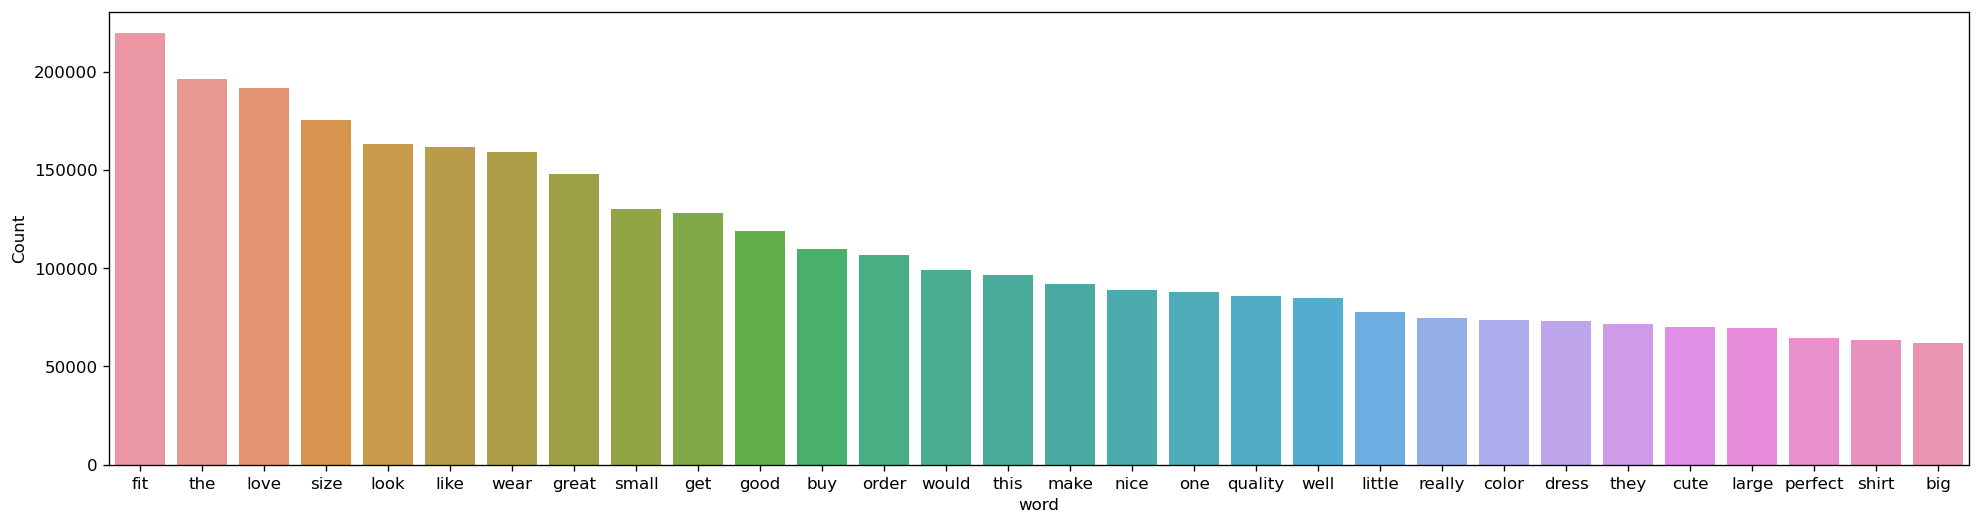

In [151]:
freq_words(df['clean'])

In [152]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

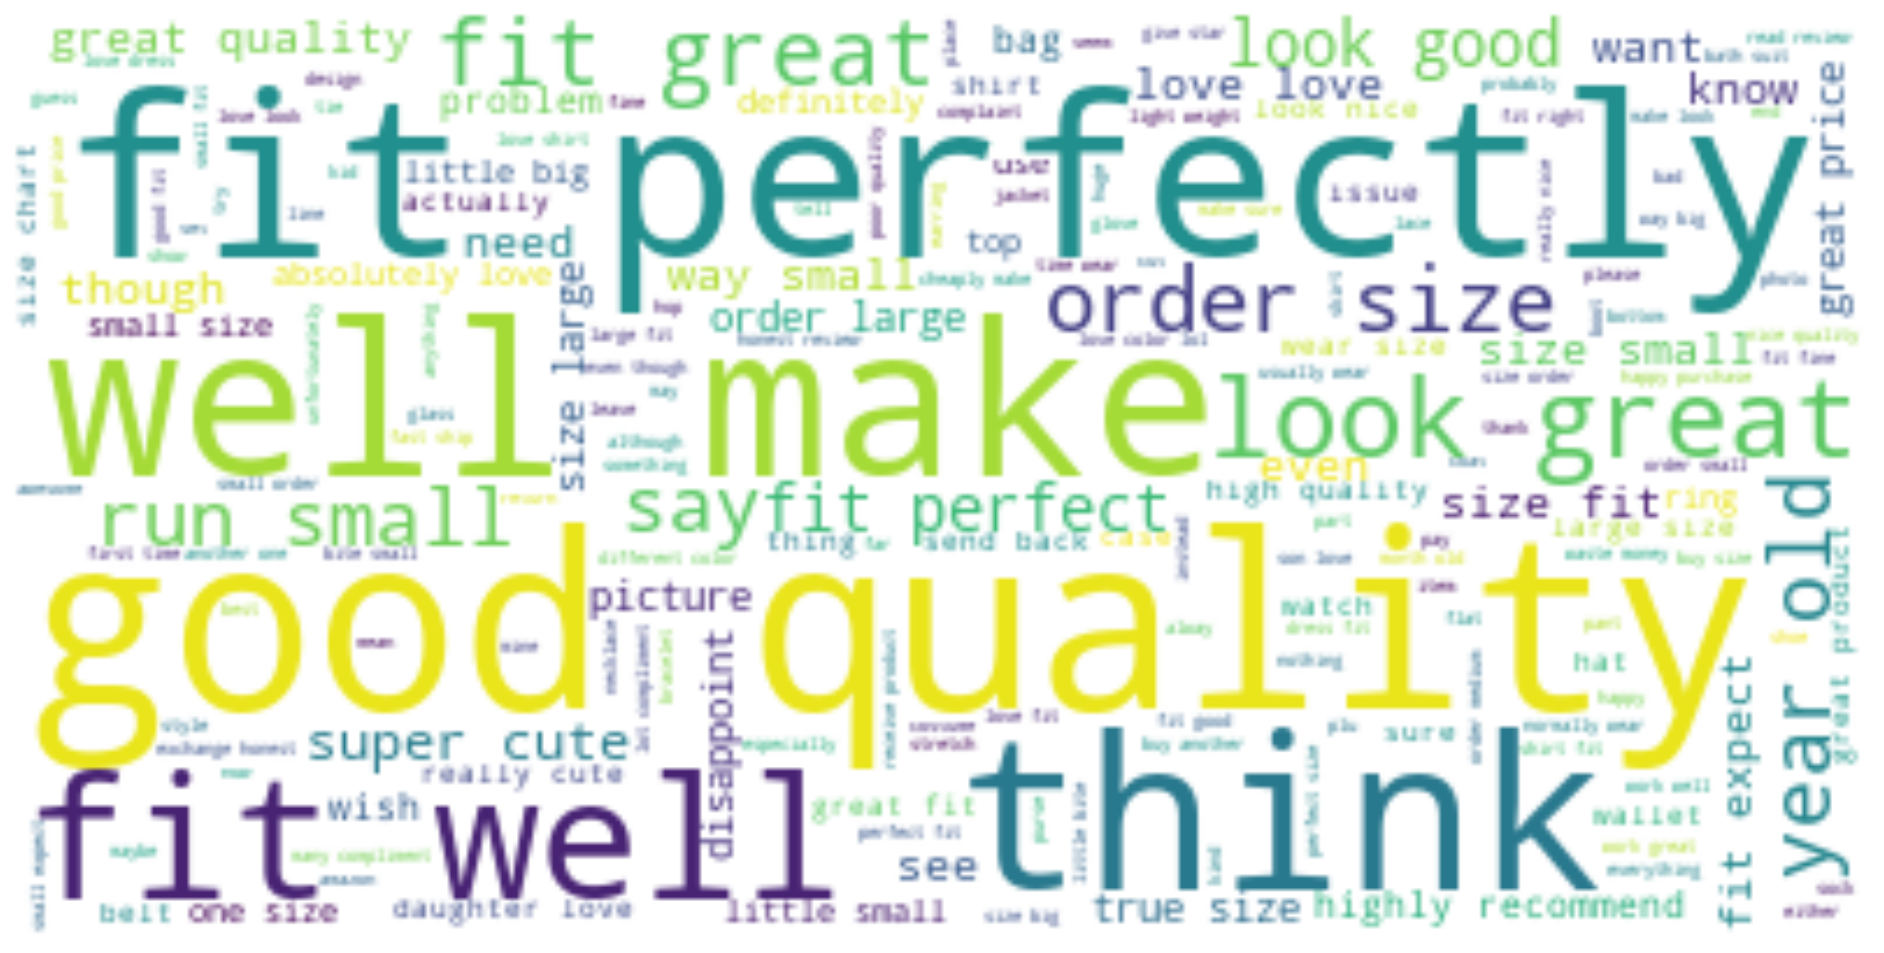

In [153]:
text = " ".join(i for i in df['clean'])
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Feature Extraction

In [154]:
from nltk.collocations import *
from nltk.util import ngrams

In [155]:
word_list = ' '.join([i for i in df['clean']]).split()

In [156]:
(pd.Series(nltk.ngrams(word_list, 2)).value_counts())[:20]

(look, like)          23871
(good, quality)       20403
(fit, perfectly)      18178
(well, make)          17543
(fit, well)           16283
(look, great)         15091
(fit, great)          15007
(order, size)         13865
(like, picture)       12999
(year, old)           12300
(love, them)          12195
(run, small)          11511
(fit, perfect)        11172
(really, like)        10876
(look, good)          10779
(the, material)       10348
(super, cute)         10114
(great, quality)       9901
(would, recommend)     9472
(size, small)          9298
dtype: int64

In [157]:
(pd.Series(nltk.ngrams(word_list, 3)).value_counts())[:20]

(look, like, picture)             4706
(love, love, love)                3128
(get, lot, compliment)            3115
(get, pay, for)                   2970
(get, many, compliment)           2772
(receive, product, discount)      2522
(nothing, like, picture)          2441
(honest, unbiased, review)        2305
(order, size, large)              2166
(would, buy, again)               2112
(look, nothing, like)             2100
(exchange, honest, review)        2019
(would, definitely, recommend)    1877
(fit, true, size)                 1876
(exchange, honest, unbiased)      1866
(discount, exchange, honest)      1865
(one, size, fit)                  1815
(look, exactly, like)             1790
(run, little, small)              1734
(exactly, like, picture)          1715
dtype: int64

In [158]:
search_word = ["love", "like", "hate", "great", "nice", 'the']

no_opinion = ' '.join((filter(lambda val: val not in search_word, list(word_list)))).split()

In [159]:
(pd.Series(nltk.ngrams(no_opinion, 2)).value_counts())[:20]

(good, quality)        20528
(fit, perfectly)       18182
(well, make)           17548
(fit, well)            16368
(order, size)          13935
(year, old)            12300
(run, small)           11521
(fit, perfect)         11315
(look, good)           11164
(super, cute)          10115
(would, recommend)      9484
(size, small)           9372
(way, small)            9030
(size, fit)             8869
(fit, expect)           8245
(order, large)          7972
(true, size)            7943
(size, large)           7892
(think, would)          7678
(highly, recommend)     7576
dtype: int64

In [160]:
(pd.Series(nltk.ngrams(no_opinion, 3)).value_counts())[:20]

(get, lot, compliment)            3123
(get, pay, for)                   2970
(get, many, compliment)           2787
(receive, product, discount)      2530
(honest, unbiased, review)        2305
(order, size, large)              2176
(would, buy, again)               2117
(exchange, honest, review)        2019
(fit, true, size)                 1935
(would, definitely, recommend)    1877
(exchange, honest, unbiased)      1866
(discount, exchange, honest)      1865
(one, size, fit)                  1829
(look, exactly, picture)          1737
(run, little, small)              1734
(receive, many, compliment)       1669
(year, old, daughter)             1658
(can, wait, wear)                 1546
(exactly, look, for)              1516
(order, one, size)                1462
dtype: int64

## Sentiment Analysis

In [161]:
review['overall'].value_counts()
df['rating'] = review['overall']

In [162]:
def label_func(rating):
    if rating <= 2:
        return 'negative'
    if rating >= 4:
        return 'positive'
    else:
        return 'neutral'

df['sentiment'] = df['rating'].apply(label_func)

In [163]:
positive_review = df[(df["sentiment"] == 'positive')]['clean'].to_frame()
neutral_review = df[(df["sentiment"] == 'neutral')]['clean'].to_frame()
negative_review = df[(df["sentiment"] == 'negative')]['clean'].to_frame()

In [164]:
pos_clean = ' '.join([i for i in positive_review['clean']]).split()
neutral_clean = ' '.join([i for i in neutral_review['clean']]).split()
neg_clean = ' '.join([i for i in negative_review['clean']]).split()

In [165]:
pos_clean = ' '.join((filter(lambda val: val not in search_word, list(pos_clean)))).split()
neutral_clean = ' '.join((filter(lambda val: val not in search_word, list(neutral_clean)))).split()
neg_clean = ' '.join((filter(lambda val: val not in search_word, list(neg_clean)))).split()

In [166]:
text_corpus_positive_review = ' '.join(pos_clean)
text_corpus_neutral_review = ' '.join(neutral_clean)
text_corpus_negative_review = ' '.join(neg_clean)

In [167]:
def most_common_word_func(text, n_words=25):

    words = word_tokenize(text)
    fdist = FreqDist(words) 
    
    n_words = n_words
    
    df_fdist = pd.DataFrame({'Word': fdist.keys(),
                             'Frequency': fdist.values()})
    df_fdist = df_fdist.sort_values(by='Frequency', ascending=False).head(n_words)
    
    return df_fdist

In [168]:
df_most_common_words_text_corpus_positive_review = most_common_word_func(text_corpus_positive_review)
df_most_common_words_text_corpus_neutral_review = most_common_word_func(text_corpus_neutral_review)
df_most_common_words_text_corpus_negative_review = most_common_word_func(text_corpus_negative_review)

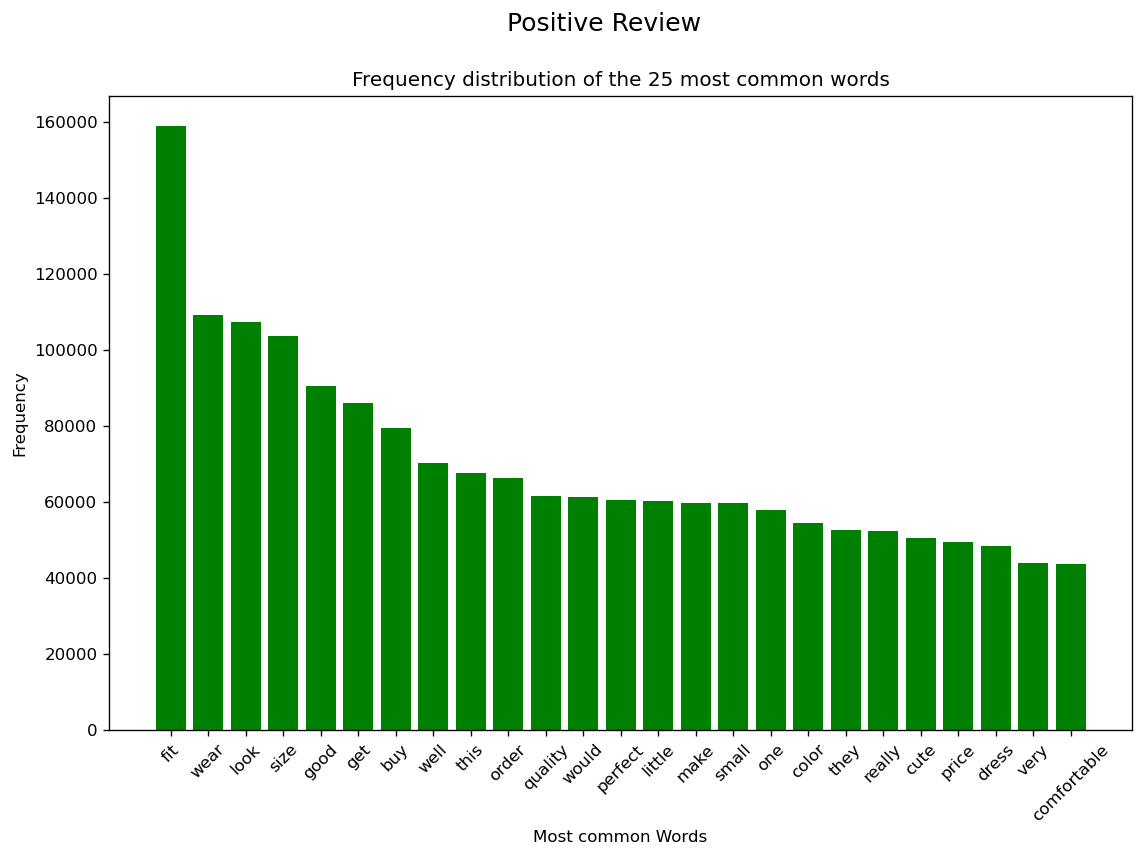

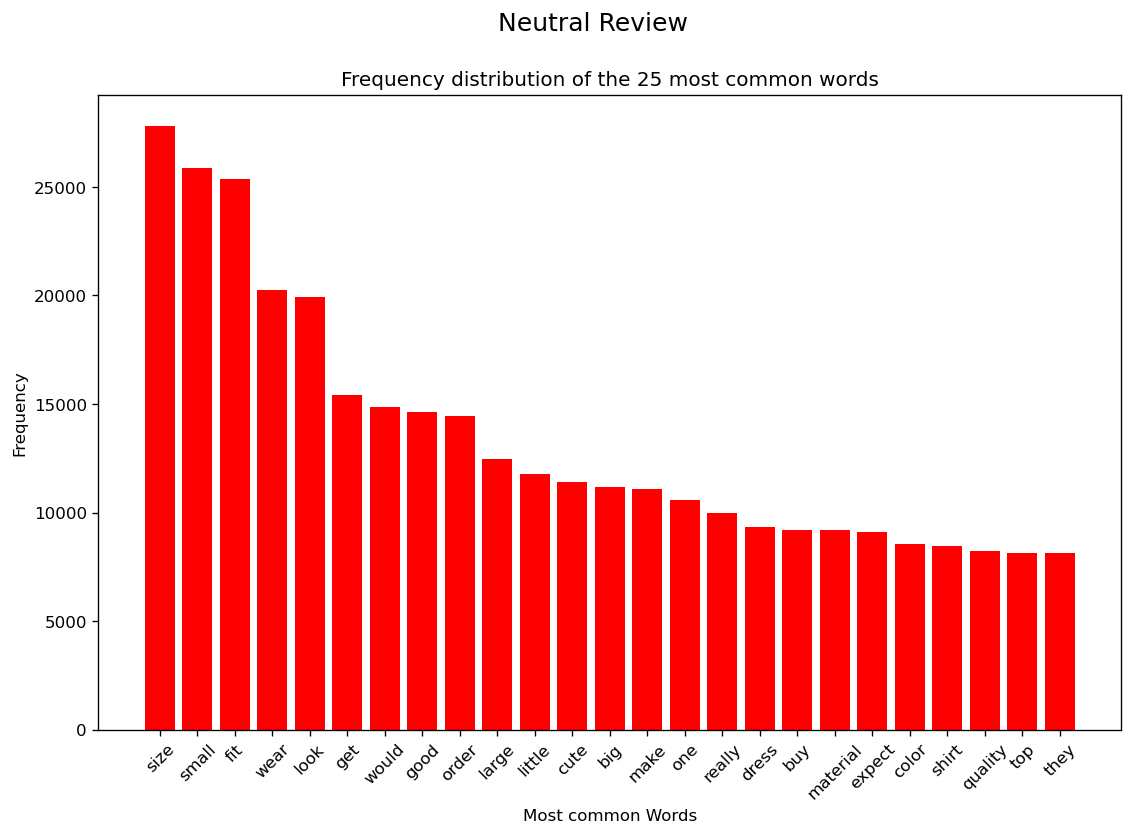

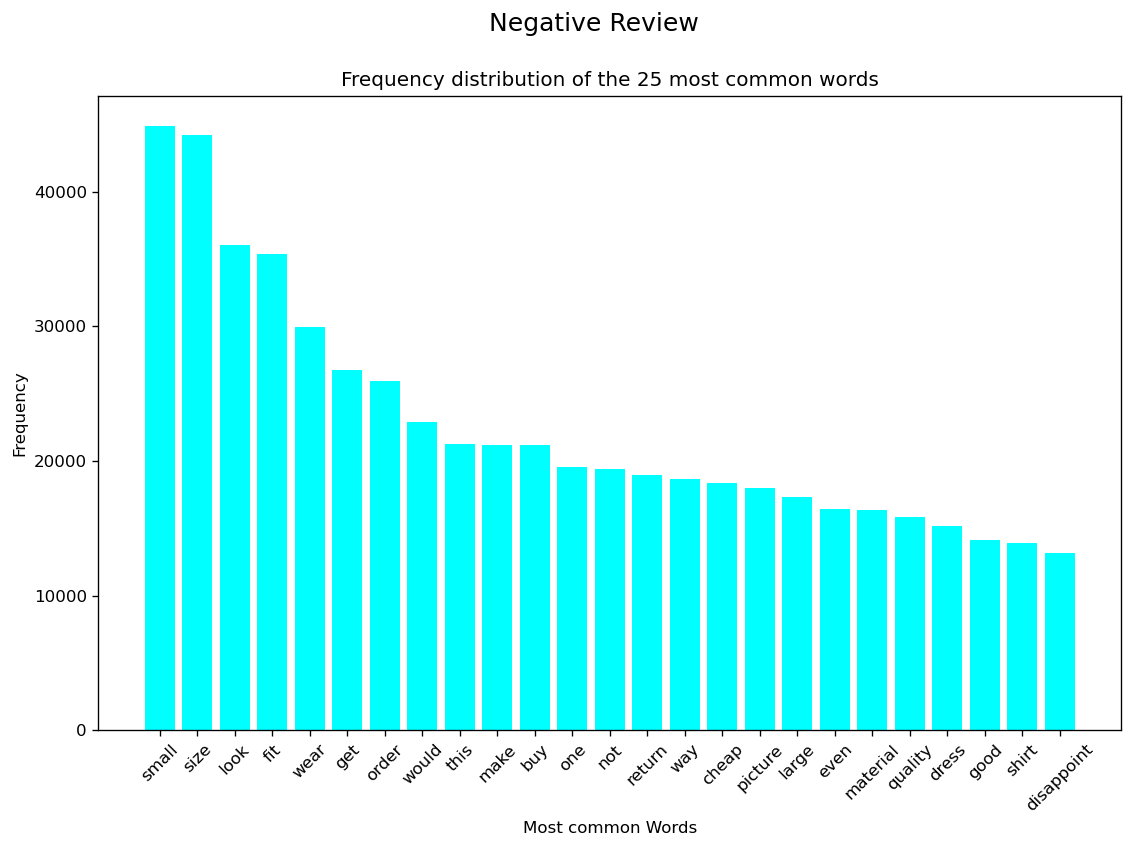

In [169]:
splited_data = [df_most_common_words_text_corpus_positive_review,
                df_most_common_words_text_corpus_neutral_review,
                df_most_common_words_text_corpus_negative_review]

color_list = ['green', 'red', 'cyan']
title_list = ['Positive Review', 'Neutral Review', 'Negative Review']


for item in range(3):
    plt.figure(figsize=(11,7))
    plt.bar(splited_data[item]['Word'], 
            splited_data[item]['Frequency'],
            color=color_list[item])
    plt.xticks(rotation = 45)
    plt.xlabel('Most common Words')
    plt.ylabel("Frequency")
    plt.title("Frequency distribution of the 25 most common words")
    plt.suptitle(title_list[item], fontsize=15)
    plt.show()

## Topic Modeling

In [170]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

dictionary = corpora.Dictionary(df['tokenized'])

In [171]:
doc_term_matrix = [dictionary.doc2bow(word) for word in df['tokenized']]

In [172]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [173]:
##lda_model_1 = Lda_object(DT_matrix, num_topics=2, id2word = dictionary)

print(lda_model.print_topics(num_topics=6, num_words=5))

[(4, '0.057*"it" + 0.047*"my" + 0.029*"daughter" + 0.026*"loved" + 0.026*"loves"'), (0, '0.038*"the" + 0.032*"i" + 0.029*"like" + 0.029*"it" + 0.016*"dress"'), (3, '0.087*"i" + 0.032*"it" + 0.021*"product" + 0.018*"love" + 0.017*"beautiful"'), (5, '0.060*"great" + 0.059*"good" + 0.053*"quality" + 0.050*"very" + 0.040*"nice"'), (1, '0.105*"i" + 0.020*"one" + 0.011*"time" + 0.009*"first" + 0.009*"get"'), (6, '0.054*"i" + 0.036*"they" + 0.034*"love" + 0.024*"comfortable" + 0.019*"wear"')]


In [174]:
from textblob import TextBlob

df = df[df.Token_Count>2] # Whole Dataset

def norm_lemm_v_a_func_token(text):
    '''
    Lemmatize tokens
    
    Step 1: Use WordNetLemmatizer() with POS tag 'v' to lemmatize the created tokens     
    Step 2: Use WordNetLemmatizer() with POS tag 'a' to lemmatize the created tokens
    
    Args:
        text (str): String to which the functions are to be applied, string
    
    Returns:
        String with lemmatized words
    '''

    text1 = [WordNetLemmatizer().lemmatize(word, pos='v') for word in text]
    text2 = [WordNetLemmatizer().lemmatize(word, pos='a') for word in text1]
    return text2

# Filter out nouns (product-related features), verbs and subjective adverbs & adjs which reflect strong customer opinions.
word_len_threshold = 2
df['tagged_filtered'] = df['tagged'].apply(lambda x: [word for word, tag in x 
                                                    if len(word) > word_len_threshold and
                                                        (   tag.startswith("N") 
                                                        or tag.startswith("V")
                                                        or (tag.startswith("RB") and TextBlob(word).sentiment.subjectivity>0)
                                                        or (tag.startswith("J") and TextBlob(word).sentiment.subjectivity>0)  )])

df["tokenized_filtered"] = df['tagged_filtered'].apply(norm_lemm_v_a_func_token)

df

,reviewText,noHTML,noStopword,tokenized,tagged,nouns,verbs,adjs,adverbs,Token_Count,lemmatized,clean,rating,sentiment,tagged_filtered,tokenized_filtered,bigram
0,Exactly what I needed.,Exactly what I needed.,exactly i needed,"[exactly, i, needed]","[(exactly, RB), (i, NN), (needed, VBD)]",[i],[needed],[],[exactly],3,exactly i need,exactly need,5,positive,"[exactly, needed]","[exactly, need]",[exactly need]
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree review opening small i almost bent hook expensive earrings trying get higher end they re seen would buy price sending back,"[i, agree, review, opening, small, i, almost, bent, hook, expensive, earrings, trying, get, higher, end, they, re, seen, would, buy, price, sending, back]","[(i, JJ), (agree, VBP), (review, NN), (opening, VBG), (small, JJ), (i, NN), (almost, RB), (bent, JJ), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (higher, JJR), (end, N...","[review, i, hook, earrings, end, price]","[agree, opening, trying, get, re, seen, buy, sending]","[i, small, bent, expensive, higher]",[almost],23,i agree review open small i almost bend hook expensive earrings try get high end they re see would buy price send back,agree review open small almost bend hook expensive earrings try get high end they see would buy price send back,2,negative,"[agree, review, opening, small, hook, expensive, earrings, trying, get, higher, end, seen, buy, price, sending]","[agree, review, open, small, hook, expensive, earrings, try, get, high, end, see, buy, price, send]","[agree review, review open, open small, small almost, almost bend, bend hook, hook expensive, expensive earrings, earrings try, try get, get high, high end, end they, they see, see would, would bu..."
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i going order another pack keep work someone including myself always losing back earring i understand fish hook earrings them just wish tiny bit longer,"[love, these, i, going, order, another, pack, keep, work, someone, including, myself, always, losing, back, earring, i, understand, fish, hook, earrings, them, just, wish, tiny, bit, longer]","[(love, IN), (these, DT), (i, NNS), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (someone, NN), (including, VBG), (myself, PRP), (always, RB), (losing, VBG), (back...","[i, order, pack, keep, work, someone, i, hook, bit]","[going, including, losing, earring, understand, earrings, wish]","[fish, tiny]","[always, just, longer]",27,love these i go order another pack keep work someone include myself always lose back earring i understand fish hook earrings them just wish tiny bite long,love these order another pack keep work someone include myself always lose back earring understand fish hook earrings them just wish tiny bite long,4,positive,"[going, order, pack, keep, work, someone, including, losing, earring, understand, hook, earrings, wish, tiny, bit]","[go, order, pack, keep, work, someone, include, lose, earring, understand, hook, earrings, wish, tiny, bite]","[love these, these order, order another, another pack, pack keep, keep work, work someone, someone include, include myself, myself always, always lose, lose back, back earring, earring understand,..."
5,Exactly what I wanted.,

In [175]:
def ngram(text):
    """
    Transform the review text into all bigram and trigram combinations.
    
    Input: String of text.
    
    Output: A list of all bigram and trigram combinations of the input text. Each combination is a string.
    
    """
    return [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 2))] + [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 3))]

df["bigram"] = df["clean"].apply(ngram)

In [176]:
# Divide dictonary into three sentiment states to understand the main user opinions in each of them.
df_pos = df[df.sentiment=="positive"]
df_neu = df[df.sentiment=="neutral"]
df_neg = df[df.sentiment=="negative"]

pos_dictionary = corpora.Dictionary(df_pos['tokenized_filtered'])
neu_dictionary = corpora.Dictionary(df_neu['tokenized_filtered'])
neg_dictionary = corpora.Dictionary(df_neg['tokenized_filtered'])

# Filter out tokens appear in 1) less than 1% of all reviews. (less representative) (no ) 2) more than 80% of all reviews (no benefit for topic distinguishing).
pos_dictionary.filter_extremes(no_below=0.01*len(pos_dictionary.token2id), no_above=0.8) 
neu_dictionary.filter_extremes(no_below=0.01*len(neu_dictionary.token2id), no_above=0.8) 
neg_dictionary.filter_extremes(no_below=0.01*len(neg_dictionary.token2id), no_above=0.8)

pos_doc_term_matrix = [pos_dictionary.doc2bow(word) for word in df_pos['tokenized_filtered']]
neu_doc_term_matrix = [neu_dictionary.doc2bow(word) for word in df_neu['tokenized_filtered']]
neg_doc_term_matrix = [neg_dictionary.doc2bow(word) for word in df_neg['tokenized_filtered']]

In [179]:
# LDA model parameter tuning

LDA = gensim.models.ldamodel.LdaModel

pos_lda_model = LDA(corpus=pos_doc_term_matrix, id2word=pos_dictionary, num_topics=10, random_state=100, chunksize=100, passes=10)
neu_lda_model = LDA(corpus=neu_doc_term_matrix, id2word=neu_dictionary, num_topics=10, random_state=100, chunksize=100, passes=10)
neg_lda_model = LDA(corpus=neg_doc_term_matrix, id2word=neg_dictionary, num_topics=10, random_state=100, chunksize=100, passes=10)

In [180]:
# Topics in positive reviews.

print(pos_lda_model.print_topics(num_topics=10, num_words=5))

[(0, '0.165*"great" + 0.095*"fit" + 0.083*"shirt" + 0.071*"nice" + 0.067*"look"'), (1, '0.097*"size" + 0.075*"fit" + 0.063*"dress" + 0.063*"order" + 0.051*"love"'), (2, '0.148*"comfortable" + 0.101*"wear" + 0.089*"love" + 0.060*"shoe" + 0.051*"gift"'), (3, '0.043*"use" + 0.039*"keep" + 0.034*"summer" + 0.027*"cover" + 0.024*"cool"'), (4, '0.092*"small" + 0.047*"really" + 0.044*"look" + 0.033*"need" + 0.026*"medium"'), (5, '0.063*"very" + 0.054*"review" + 0.046*"receive" + 0.046*"beautiful" + 0.045*"color"'), (6, '0.068*"top" + 0.065*"little" + 0.064*"big" + 0.049*"pretty" + 0.048*"work"'), (7, '0.163*"good" + 0.119*"quality" + 0.080*"expect" + 0.075*"product" + 0.054*"price"'), (8, '0.035*"time" + 0.031*"long" + 0.031*"purchase" + 0.029*"short" + 0.028*"discount"'), (9, '0.208*"love" + 0.162*"cute" + 0.085*"soft" + 0.067*"super" + 0.046*"great"')]


The positive reviews mainly centered around the following topics:

1. Product Quality:
    (1) Material: "soft", "top"
    (2) Size: "fit"
    (3) Style: "cute", "look as expected", "color"
2. Product Price
    (1) "discount"
    (2) "worth the price"
    
Especially, many adverbs and adjs are used to express their strong satisfaction (different from neu/neg reviews): top, very, great, love, super, really.
   
This reveals that customers cares about product quality and prices, with material, size, style, discount as top deciding fatcors. They would describe good products as "look as expected from pictures".

In [181]:
# Topics in neutral reviews.

print(neu_lda_model.print_topics(num_topics=10, num_words=5))

[(0, '0.066*"keep" + 0.056*"use" + 0.054*"arm" + 0.046*"old" + 0.046*"daughter"'), (1, '0.057*"suit" + 0.057*"receive" + 0.055*"price" + 0.043*"get" + 0.035*"style"'), (2, '0.078*"look" + 0.077*"color" + 0.061*"cute" + 0.060*"picture" + 0.057*"shirt"'), (3, '0.174*"dress" + 0.087*"short" + 0.049*"fit" + 0.045*"bite" + 0.040*"show"'), (4, '0.159*"size" + 0.129*"small" + 0.089*"order" + 0.072*"large" + 0.064*"fit"'), (5, '0.058*"see" + 0.058*"review" + 0.029*"wash" + 0.028*"say" + 0.027*"beautiful"'), (6, '0.151*"top" + 0.070*"product" + 0.040*"design" + 0.032*"return" + 0.032*"bad"'), (7, '0.077*"love" + 0.059*"time" + 0.057*"pretty" + 0.054*"very" + 0.047*"wear"'), (8, '0.031*"give" + 0.030*"medium" + 0.028*"fit" + 0.027*"think" + 0.024*"bottom"'), (9, '0.076*"good" + 0.069*"little" + 0.064*"nice" + 0.061*"look" + 0.061*"material"')]


The neutral reviews mainly centered around the following topics:

1. Family:
    (1) "daugher"
2. Product Size (controversial)
    (1) Some customers stated "fit"
    (2) Some stated that size might not be just right: "large" & "small", "short", "little"
    (3) "return": Some products might be returned
3. Product Look
    (1) "nice", "cute", "like picture"
   
Compared with positive reviews, neutral reviews became more controversial in consumer opinions, especially in product size. Many customers might be satisfied with the product quality and look, but just the size didn't fit. So they would give a neutral star.

In [182]:
# Topics in negative reviews.

print(neg_lda_model.print_topics(num_topics=10, num_words=5))

[(0, '0.127*"very" + 0.076*"money" + 0.066*"item" + 0.061*"disappoint" + 0.053*"waste"'), (1, '0.106*"make" + 0.085*"give" + 0.039*"bag" + 0.032*"cheaply" + 0.029*"put"'), (2, '0.096*"top" + 0.053*"suit" + 0.050*"wear" + 0.047*"take" + 0.044*"bottom"'), (3, '0.131*"fit" + 0.055*"love" + 0.052*"tight" + 0.044*"need" + 0.040*"big"'), (4, '0.067*"time" + 0.058*"first" + 0.053*"pretty" + 0.050*"old" + 0.040*"work"'), (5, '0.165*"quality" + 0.055*"poor" + 0.050*"use" + 0.041*"extremely" + 0.040*"strap"'), (6, '0.108*"look" + 0.085*"picture" + 0.040*"return" + 0.038*"receive" + 0.028*"show"'), (7, '0.125*"small" + 0.120*"size" + 0.062*"order" + 0.059*"fit" + 0.045*"way"'), (8, '0.059*"dress" + 0.056*"material" + 0.040*"really" + 0.035*"look" + 0.033*"shirt"'), (9, '0.091*"break" + 0.067*"come" + 0.038*"design" + 0.032*"cover" + 0.032*"part"')]


The negative reviews mainly centered around the following topics:

1. Product Size (controversial)
    (1) Some customers stated "fit" (but might be not fit and the not was not captured by topic modeling)
    (2) Some stated that size might not be just right: "large" & "small", "short", "little"
    (3) "return": Some products might be returned
2. Product Price
    (1) "cheap"
   
Compared with pos/neu reviews, negative reviews are still controversial in consumer opinions, especially in product size. Also, the product might be cheap or look cheap, which did not match customers' expectations.

In [183]:
# Aggregate review tokens into bi-grams and tri-grams to better understand structured user opinions instead of scattered words.
def ngram(text):
    """
    Transform the review text into all bigram and trigram combinations.
    
    Input: String of text.
    
    Output: A list of all bigram and trigram combinations of the input text. Each combination is a string.
    
    """
    return [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 2))] + [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 3))]


df["bigram"] = df["clean"].apply(ngram)

# Divide dictonary into three sentiment states to understand the main user opinions in each of them.
df_pos_ng = df[df.sentiment=="positive"]
df_neu_ng = df[df.sentiment=="neutral"]
df_neg_ng = df[df.sentiment=="negative"]

ng_pos_dictionary = corpora.Dictionary(df_pos_ng['bigram'])
ng_neu_dictionary = corpora.Dictionary(df_neu_ng['bigram'])
ng_neg_dictionary = corpora.Dictionary(df_neg_ng['bigram'])

# Filter out tokens appear in 1) less than 3 reviews. (less representative) (no ) 2) more than 80% of all reviews (no benefit for topic distinguishing).
ng_pos_dictionary.filter_extremes(no_below=3, no_above=0.8) 
ng_neu_dictionary.filter_extremes(no_below=3, no_above=0.8) 
ng_neg_dictionary.filter_extremes(no_below=3, no_above=0.8)

ng_pos_doc_term_matrix = [ng_pos_dictionary.doc2bow(word) for word in df_pos_ng['bigram']]
ng_neu_doc_term_matrix = [ng_neu_dictionary.doc2bow(word) for word in df_neu_ng['bigram']]
ng_neg_doc_term_matrix = [ng_neg_dictionary.doc2bow(word) for word in df_neg_ng['bigram']]

df

,reviewText,noHTML,noStopword,tokenized,tagged,nouns,verbs,adjs,adverbs,Token_Count,lemmatized,clean,rating,sentiment,tagged_filtered,tokenized_filtered,bigram
0,Exactly what I needed.,Exactly what I needed.,exactly i needed,"[exactly, i, needed]","[(exactly, RB), (i, NN), (needed, VBD)]",[i],[needed],[],[exactly],3,exactly i need,exactly need,5,positive,"[exactly, needed]","[exactly, need]",[exactly need]
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree review opening small i almost bent hook expensive earrings trying get higher end they re seen would buy price sending back,"[i, agree, review, opening, small, i, almost, bent, hook, expensive, earrings, trying, get, higher, end, they, re, seen, would, buy, price, sending, back]","[(i, JJ), (agree, VBP), (review, NN), (opening, VBG), (small, JJ), (i, NN), (almost, RB), (bent, JJ), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (higher, JJR), (end, N...","[review, i, hook, earrings, end, price]","[agree, opening, trying, get, re, seen, buy, sending]","[i, small, bent, expensive, higher]",[almost],23,i agree review open small i almost bend hook expensive earrings try get high end they re see would buy price send back,agree review open small almost bend hook expensive earrings try get high end they see would buy price send back,2,negative,"[agree, review, opening, small, hook, expensive, earrings, trying, get, higher, end, seen, buy, price, sending]","[agree, review, open, small, hook, expensive, earrings, try, get, high, end, see, buy, price, send]","[agree review, review open, open small, small almost, almost bend, bend hook, hook expensive, expensive earrings, earrings try, try get, get high, high end, end they, they see, see would, would bu..."
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i going order another pack keep work someone including myself always losing back earring i understand fish hook earrings them just wish tiny bit longer,"[love, these, i, going, order, another, pack, keep, work, someone, including, myself, always, losing, back, earring, i, understand, fish, hook, earrings, them, just, wish, tiny, bit, longer]","[(love, IN), (these, DT), (i, NNS), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (someone, NN), (including, VBG), (myself, PRP), (always, RB), (losing, VBG), (back...","[i, order, pack, keep, work, someone, i, hook, bit]","[going, including, losing, earring, understand, earrings, wish]","[fish, tiny]","[always, just, longer]",27,love these i go order another pack keep work someone include myself always lose back earring i understand fish hook earrings them just wish tiny bite long,love these order another pack keep work someone include myself always lose back earring understand fish hook earrings them just wish tiny bite long,4,positive,"[going, order, pack, keep, work, someone, including, losing, earring, understand, hook, earrings, wish, tiny, bit]","[go, order, pack, keep, work, someone, include, lose, earring, understand, hook, earrings, wish, tiny, bite]","[love these, these order, order another, another pack, pack keep, keep work, work someone, someone include, include myself, myself always, always lose, lose back, back earring, earring understand,..."
5,Exactly what I wanted.,

In [184]:
ng_pos_dictionary.token2id

{'exactly need': 0,
 'always lose': 1,
 'another pack': 2,
 'back earring': 3,
 'bite long': 4,
 'fish hook': 5,
 'just wish': 6,
 'keep work': 7,
 'lose back': 8,
 'love these': 9,
 'love these order': 10,
 'order another': 11,
 'order another pack': 12,
 'them just': 13,
 'these order': 14,
 'tiny bite': 15,
 'tiny bite long': 16,
 'wish tiny': 17,
 'wish tiny bite': 18,
 'work someone': 19,
 'exactly want': 20,
 'back work': 21,
 'earrings wish': 22,
 'favorite earrings': 23,
 'great loose': 24,
 'little plastic': 25,
 'order sooner': 26,
 'plastic back': 27,
 'these little': 28,
 'wish order': 29,
 'work great': 30,
 'around long': 31,
 'good quality': 32,
 'hold well': 33,
 'long time': 34,
 'quality merchandise': 35,
 'this brand': 36,
 'less week': 37,
 'may able': 38,
 'not really': 39,
 'one problem': 40,
 'only one': 41,
 'only one problem': 42,
 'problem product': 43,
 'product only': 44,
 'product price': 45,
 'really problem': 46,
 'retail price': 47,
 'satisfy product': 4

In [186]:
# LDA model parameter tuning

LDA = gensim.models.ldamodel.LdaModel

ng_pos_lda_model = LDA(corpus=ng_pos_doc_term_matrix, id2word=ng_pos_dictionary, num_topics=8, random_state=100, chunksize=100, passes=10)
ng_neu_lda_model = LDA(corpus=ng_neu_doc_term_matrix, id2word=ng_neu_dictionary, num_topics=8, random_state=100, chunksize=100, passes=10)
ng_neg_lda_model = LDA(corpus=ng_neg_doc_term_matrix, id2word=ng_neg_dictionary, num_topics=8, random_state=100, chunksize=100, passes=10)

In [187]:
# Topics in positive reviews.

for topic in ng_pos_lda_model.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.022*"great quality" + 0.019*"fit expect" + 0.014*"love shirt" + 0.012*"great price" + 0.008*"can wait" + 0.007*"the fit"
Topic 1: 0.025*"fit well" + 0.018*"fit perfect" + 0.017*"really like" + 0.014*"daughter love" + 0.008*"very comfortable" + 0.008*"usually wear"
Topic 2: 0.029*"well make" + 0.017*"love them" + 0.012*"look good" + 0.011*"absolutely love" + 0.010*"size large" + 0.008*"normally wear"
Topic 3: 0.028*"fit perfectly" + 0.012*"the color" + 0.011*"year old" + 0.007*"think would" + 0.006*"dress fit" + 0.006*"happy purchase"
Topic 4: 0.019*"fit great" + 0.015*"look great" + 0.014*"super cute" + 0.014*"look like" + 0.010*"love love" + 0.009*"bath suit"
Topic 5: 0.013*"the material" + 0.012*"exchange honest" + 0.012*"receive product" + 0.011*"honest review" + 0.010*"honest unbiased" + 0.009*"very nice"
Topic 6: 0.024*"love dress" + 0.014*"the fabric" + 0.012*"get lot" + 0.012*"lot compliment" + 0.008*"comfortable wear" + 0.008*"get lot compliment"
Topic 7: 0.014*"good

The positive reviews mainly centered around the following topics:

Pros:
1. Great quality
2. Size fit
3. Look good
4. Comfortable
5. Like Picture and Product Description
6. Discount

All compliments, very few complaints.
    
This is aligned with the word-level topic modeling on positive reviews.

In [188]:
# Topics in neutral reviews.

for topic in ng_neu_lda_model.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.037*"run small" + 0.021*"the dress" + 0.012*"the top" + 0.010*"little small" + 0.010*"small expect" + 0.008*"bite short"
Topic 1: 0.017*"size small" + 0.015*"fit like" + 0.012*"large size" + 0.008*"two size" + 0.008*"the shirt" + 0.008*"really like"
Topic 2: 0.017*"small size" + 0.014*"size chart" + 0.011*"bite small" + 0.011*"the color" + 0.008*"order small" + 0.007*"fit bite"
Topic 3: 0.015*"way small" + 0.014*"order large" + 0.013*"cute dress" + 0.010*"like picture" + 0.009*"usually wear" + 0.008*"bath suit"
Topic 4: 0.017*"order size" + 0.010*"fit well" + 0.010*"super cute" + 0.010*"see through" + 0.009*"size large" + 0.009*"really cute"
Topic 5: 0.015*"well make" + 0.008*"fit small" + 0.008*"little tight" + 0.006*"fit perfect" + 0.006*"tank top" + 0.005*"three star"
Topic 6: 0.025*"the material" + 0.017*"the fabric" + 0.012*"order medium" + 0.008*"seem like" + 0.007*"this shirt" + 0.007*"wear order"
Topic 7: 0.020*"look like" + 0.012*"good quality" + 0.008*"think would"

The neutral reviews mainly centered around the following topics:

Pros:
1. Great quality
2. Size fit (for some)
3. Look good

Cons:
1. Size might be too large or small. Not fitting well.

Compliments and complaints mixed together.
    
This is aligned with the word-level topic modeling on neutral reviews. The major complaints centered around size due to online shopping.

In [189]:
# Topics in negative reviews.

for topic in ng_neg_lda_model.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.036*"look like" + 0.021*"nothing like" + 0.011*"look nothing" + 0.011*"look nothing like" + 0.010*"size large" + 0.008*"the shirt"
Topic 1: 0.020*"like picture" + 0.015*"run small" + 0.014*"waste money" + 0.011*"order large" + 0.011*"the material" + 0.010*"look like"
Topic 2: 0.025*"way small" + 0.014*"fit like" + 0.013*"send back" + 0.011*"year old" + 0.011*"cheaply make" + 0.008*"too small"
Topic 3: 0.013*"the dress" + 0.013*"the top" + 0.012*"the size" + 0.012*"size big" + 0.009*"the bottom" + 0.008*"fell apart"
Topic 4: 0.027*"poor quality" + 0.025*"order size" + 0.013*"poorly make" + 0.012*"would recommend" + 0.010*"look cheap" + 0.008*"make look"
Topic 5: 0.024*"size small" + 0.014*"small size" + 0.012*"good quality" + 0.011*"cheap material" + 0.009*"can not" + 0.008*"read review"
Topic 6: 0.013*"bath suit" + 0.010*"feel like" + 0.010*"even though" + 0.009*"wear medium" + 0.008*"fall apart" + 0.008*"order medium"
Topic 7: 0.020*"very disappoint" + 0.009*"fit well" + 0.

The negative reviews mainly centered around the following topics:

Cons:
1. Size: Not fitting well ("way big", "extra large").
2. Quality: "poorly make", "poor quality", "look cheap", "fall apart", "cheaply make".
3. Expectation: "very disappointing", "send back", "nothing like picture".
4. Price: "waste money".

Mostly complaints, few compliments.
    
This is aligned with the word-level topic modeling on negative reviews. The major complaints centered around size, quality, price, not as expectation. Customers also mentioned that they sended back the products.

In [191]:
# Try another set of params
def ngram(text):
    """
    Transform the review text into all bigram and trigram combinations.
    
    Input: String of text.
    
    Output: A list of all bigram and trigram combinations of the input text. Each combination is a string.
    
    """
    return [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 2))] + [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 3))]


df["bigram"] = df["clean"].apply(ngram)

# Divide dictonary into three sentiment states to understand the main user opinions in each of them.
df_pos_ng = df[df.sentiment=="positive"]
df_neu_ng = df[df.sentiment=="neutral"]
df_neg_ng = df[df.sentiment=="negative"]

ng_pos_dictionary = corpora.Dictionary(df_pos_ng['bigram'])
ng_neu_dictionary = corpora.Dictionary(df_neu_ng['bigram'])
ng_neg_dictionary = corpora.Dictionary(df_neg_ng['bigram'])

# Filter out tokens appear in 1) less than 50 reviews. (less representative) (no ) 2) more than 80% of all reviews (no benefit for topic distinguishing).
ng_pos_dictionary.filter_extremes(no_below=50, no_above=0.8) 
ng_neu_dictionary.filter_extremes(no_below=50, no_above=0.8) 
ng_neg_dictionary.filter_extremes(no_below=50, no_above=0.8)

ng_pos_doc_term_matrix = [ng_pos_dictionary.doc2bow(word) for word in df_pos_ng['bigram']]
ng_neu_doc_term_matrix = [ng_neu_dictionary.doc2bow(word) for word in df_neu_ng['bigram']]
ng_neg_doc_term_matrix = [ng_neg_dictionary.doc2bow(word) for word in df_neg_ng['bigram']]

df

,reviewText,noHTML,noStopword,tokenized,tagged,nouns,verbs,adjs,adverbs,Token_Count,lemmatized,clean,rating,sentiment,tagged_filtered,tokenized_filtered,bigram
0,Exactly what I needed.,Exactly what I needed.,exactly i needed,"[exactly, i, needed]","[(exactly, RB), (i, NN), (needed, VBD)]",[i],[needed],[],[exactly],3,exactly i need,exactly need,5,positive,"[exactly, needed]","[exactly, need]",[exactly need]
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree review opening small i almost bent hook expensive earrings trying get higher end they re seen would buy price sending back,"[i, agree, review, opening, small, i, almost, bent, hook, expensive, earrings, trying, get, higher, end, they, re, seen, would, buy, price, sending, back]","[(i, JJ), (agree, VBP), (review, NN), (opening, VBG), (small, JJ), (i, NN), (almost, RB), (bent, JJ), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (higher, JJR), (end, N...","[review, i, hook, earrings, end, price]","[agree, opening, trying, get, re, seen, buy, sending]","[i, small, bent, expensive, higher]",[almost],23,i agree review open small i almost bend hook expensive earrings try get high end they re see would buy price send back,agree review open small almost bend hook expensive earrings try get high end they see would buy price send back,2,negative,"[agree, review, opening, small, hook, expensive, earrings, trying, get, higher, end, seen, buy, price, sending]","[agree, review, open, small, hook, expensive, earrings, try, get, high, end, see, buy, price, send]","[agree review, review open, open small, small almost, almost bend, bend hook, hook expensive, expensive earrings, earrings try, try get, get high, high end, end they, they see, see would, would bu..."
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i going order another pack keep work someone including myself always losing back earring i understand fish hook earrings them just wish tiny bit longer,"[love, these, i, going, order, another, pack, keep, work, someone, including, myself, always, losing, back, earring, i, understand, fish, hook, earrings, them, just, wish, tiny, bit, longer]","[(love, IN), (these, DT), (i, NNS), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (someone, NN), (including, VBG), (myself, PRP), (always, RB), (losing, VBG), (back...","[i, order, pack, keep, work, someone, i, hook, bit]","[going, including, losing, earring, understand, earrings, wish]","[fish, tiny]","[always, just, longer]",27,love these i go order another pack keep work someone include myself always lose back earring i understand fish hook earrings them just wish tiny bite long,love these order another pack keep work someone include myself always lose back earring understand fish hook earrings them just wish tiny bite long,4,positive,"[going, order, pack, keep, work, someone, including, losing, earring, understand, hook, earrings, wish, tiny, bit]","[go, order, pack, keep, work, someone, include, lose, earring, understand, hook, earrings, wish, tiny, bite]","[love these, these order, order another, another pack, pack keep, keep work, work someone, someone include, include myself, myself always, always lose, lose back, back earring, earring understand,..."
5,Exactly what I wanted.,

In [192]:
# LDA model parameter tuning

LDA = gensim.models.ldamodel.LdaModel

ng_pos_lda_model2 = LDA(corpus=ng_pos_doc_term_matrix, id2word=ng_pos_dictionary, num_topics=8, random_state=100, chunksize=100, passes=10)
ng_neu_lda_model2 = LDA(corpus=ng_neu_doc_term_matrix, id2word=ng_neu_dictionary, num_topics=8, random_state=100, chunksize=100, passes=10)
ng_neg_lda_model2 = LDA(corpus=ng_neg_doc_term_matrix, id2word=ng_neg_dictionary, num_topics=8, random_state=100, chunksize=100, passes=10)

In [193]:
# Topics in positive reviews.

for topic in ng_pos_lda_model2.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.016*"order size" + 0.013*"love them" + 0.010*"very cute" + 0.008*"highly recommend" + 0.008*"the fabric" + 0.008*"size large"
Topic 1: 0.015*"exchange honest" + 0.014*"really like" + 0.012*"honest unbiased" + 0.011*"honest review" + 0.011*"unbiased review" + 0.010*"absolutely love"
Topic 2: 0.027*"fit well" + 0.025*"look great" + 0.015*"daughter love" + 0.014*"bath suit" + 0.011*"little big" + 0.007*"love this"
Topic 3: 0.024*"good quality" + 0.014*"receive product" + 0.011*"product discount" + 0.011*"look good" + 0.009*"receive product discount" + 0.009*"this dress"
Topic 4: 0.027*"look like" + 0.024*"great quality" + 0.015*"like picture" + 0.013*"great price" + 0.010*"feel like" + 0.009*"can wait"
Topic 5: 0.025*"fit great" + 0.019*"super cute" + 0.013*"true size" + 0.010*"run small" + 0.010*"order large" + 0.009*"would recommend"
Topic 6: 0.031*"well make" + 0.019*"fit perfect" + 0.018*"love dress" + 0.016*"love love" + 0.015*"the color" + 0.012*"love shirt"
Topic 7: 0.03

In [194]:
# Topics in neutral reviews.

for topic in ng_neu_lda_model2.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.027*"size large" + 0.027*"small size" + 0.019*"honest review" + 0.019*"little small" + 0.017*"the shirt" + 0.017*"exchange honest"
Topic 1: 0.071*"run small" + 0.034*"good quality" + 0.029*"see through" + 0.029*"really cute" + 0.023*"small order" + 0.014*"get size"
Topic 2: 0.037*"size small" + 0.036*"the material" + 0.034*"order large" + 0.025*"the fabric" + 0.018*"really like" + 0.017*"order medium"
Topic 3: 0.039*"the dress" + 0.028*"super cute" + 0.021*"year old" + 0.019*"small expect" + 0.018*"bath suit" + 0.018*"chest area"
Topic 4: 0.041*"look like" + 0.020*"large size" + 0.017*"like picture" + 0.016*"well make" + 0.016*"look good" + 0.014*"get pay"
Topic 5: 0.024*"the bottom" + 0.017*"fit fine" + 0.017*"little tight" + 0.016*"the fit" + 0.015*"fit top" + 0.015*"the quality"
Topic 6: 0.052*"order size" + 0.023*"size chart" + 0.022*"size big" + 0.022*"usually wear" + 0.019*"wear size" + 0.017*"the color"
Topic 7: 0.037*"way small" + 0.036*"fit like" + 0.032*"fit well" 

In [195]:
# Topics in negative reviews.

for topic in ng_neg_lda_model2.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.041*"poor quality" + 0.040*"waste money" + 0.020*"large size" + 0.019*"poorly make" + 0.017*"the size" + 0.014*"can not"
Topic 1: 0.053*"like picture" + 0.028*"the material" + 0.024*"nothing like" + 0.023*"nothing like picture" + 0.014*"look cheap" + 0.013*"get pay"
Topic 2: 0.032*"run small" + 0.031*"fit like" + 0.018*"too small" + 0.015*"size large" + 0.014*"would recommend" + 0.014*"way big"
Topic 3: 0.018*"the dress" + 0.018*"the top" + 0.018*"bath suit" + 0.017*"wear size" + 0.013*"this product" + 0.012*"the bottom"
Topic 4: 0.071*"look like" + 0.022*"very disappoint" + 0.018*"see through" + 0.015*"this dress" + 0.013*"size order" + 0.012*"the fabric"
Topic 5: 0.032*"year old" + 0.032*"cheaply make" + 0.026*"send back" + 0.020*"look nothing" + 0.020*"look nothing like" + 0.019*"would fit"
Topic 6: 0.032*"size small" + 0.028*"order large" + 0.022*"size chart" + 0.018*"small size" + 0.015*"think would" + 0.013*"fit well"
Topic 7: 0.062*"way small" + 0.030*"order size" + 0

## Feature Extraction

In [196]:
# Create an overall table that takes other variables into consideration
from datetime import datetime
data = pd.concat([review[["reviewTime", "reviewerID","reviewerName","vote"]], df], axis=1).reset_index(drop=True)
data = data[data.Token_Count>2]
data["vote"].fillna(0, inplace=True)
data["reviewTime"] = ["-".join(np.array(date.replace(",", "").split())[[2,0,1]]) for date in data["reviewTime"]]
data["reviewTime"] = [datetime. strptime(date[:-1]+"0"+date[-1], '%Y-%m-%d') if len(date)<10 
                                      else datetime. strptime(date, '%Y-%m-%d') for date in data["reviewTime"]]
max_date = data["reviewTime"].max()
data["day_gap"] = [(max_date - date).days for date in data["reviewTime"]]
data["year-month"] = [date.strftime("%Y-%m") for date in data["reviewTime"]]
data["year"] = [date.strftime("%Y") for date in data["reviewTime"]]
data.head(3)

,reviewTime,reviewerID,reviewerName,vote,reviewText,noHTML,noStopword,tokenized,tagged,nouns,...,lemmatized,clean,rating,sentiment,tagged_filtered,tokenized_filtered,bigram,day_gap,year-month,year
0,2014-10-20,A1D4G1SNUZWQOT,Tracy,0.0,Exactly what I needed.,Exactly what I needed.,exactly i needed,"[exactly, i, needed]","[(exactly, RB), (i, NN), (needed, VBD)]",[i],...,exactly i need,exactly need,5.0,positive,"[exactly, needed]","[exactly, need]",[exactly need],1442,2014-10,2014
1,2014-09-28,A3DDWDH9PX2YX2,Sonja Lau,3.0,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree review opening small i almost bent hook expensive earrings trying get higher end they re seen would buy price sending back,"[i, agree, review, opening, small, i, almost, bent, hook, expensive, earrings, trying, get, higher, end, they, re, seen, would, buy, price, sending, back]","[(i, JJ), (agree, VBP), (review, NN), (opening, VBG), (small, JJ), (i, NN), (almost, RB), (bent, JJ), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (higher, JJR), (end, N...","[review, i, hook, earrings, end, price]",...,i agree review open small i almost bend hook expensive earrings try get high end they re see would buy price send back,agree review open small almost bend hook expensive earrings try get high end they see would buy price send back,2.0,negative,"[agree, review, opening, small, hook, expensive, earrings, trying, get, higher, end, seen, buy, price, sending]","[agree, review, open, small, hook, expensive, earrings, try, get, high, end, see, buy, price, send]","[agree review, review open, open small, small almost, almost bend, bend hook, hook expensive, expensive earrings, earrings try, try get, get high, high end, end they, they see, see would, would bu...",1464,2014-09,2014
2,2014-08-25,A2MWC41EW7XL15,Kathleen,0.0,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i going order another pack keep work someone including myself always losing back earring i understand fish hook earrings them just wish tiny bit longer,"[love, these, i, going, order, another, pack, keep, work, someone, including, myself, always, losing, back, earring, i, understand, fish, hook, earrings, them, just, wish, tiny, bit, longer]","[(love, IN), (these, DT), (i, NNS), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (someone, NN), (including, VBG), (myself, PRP), (always, RB), (losing, VBG), (back...","[i, order, pack, keep, work, someone, i, hook, bit]",...,love these i go order another pack keep work someone include myself always lose back earring i understand fish hook earrings them just wish tiny bite long,love these order another pack keep work someone include myself always lose back earring understand fish hook earrings them just wish tiny bite long,4.0,positive,"[going, order, pack, keep, work, someone, including, losing, earring, understand, hook, earrings, wish, tiny, bit]","[go, order, pack, keep, work, someone, include, lose, earring, understand, hook, earrings, wish, tiny, bite]","[love these, these order, order another, another pack, pack keep, keep work, work someone, someone include, include myself, myself always, always lose, lose back, back earring, earring understand,...",1498,2014-08,2014


In [197]:
# Check missing values: Only reviewerName has 81 missing values, could be ignored for now.
data.isnull().sum()

reviewTime             0
reviewerID             0
reviewerName          81
vote                   0
reviewText             0
noHTML                 0
noStopword             0
tokenized              0
tagged                 0
nouns                  0
verbs                  0
adjs                   0
adverbs                0
Token_Count            0
lemmatized             0
clean                  0
rating                 0
sentiment              0
tagged_filtered        0
tokenized_filtered     0
bigram                 0
day_gap                0
year-month             0
year                   0
dtype: int64

In [198]:
data["vote"].sort_values().value_counts()

0.0      694923
2.0       31516
3.0       14913
4.0        8049
5.0        5196
          ...  
203.0         1
206.0         1
143.0         1
222.0         1
966.0         1
Name: vote, Length: 201, dtype: int64

In [199]:
data[["vote","day_gap"]].corr()

,vote,day_gap
vote,1.000000,0.079949
day_gap,0.079949,1.000000


A high portion of review votes are 0, indicating they were not endorsed (or viewed) by any readers. The correlation between helpfulness votes and review publish dates (day_gap = max publish date - this review's publish date, counted in days) is low, indicating review views induced by publish time might not affect votes significantly.

In [200]:
data["rating"].sort_values().value_counts()

5.0    391059
4.0    133997
1.0     97926
3.0     89810
2.0     60059
Name: rating, dtype: int64

Text(0.5, 1.0, 'Distribution of User Ratings')

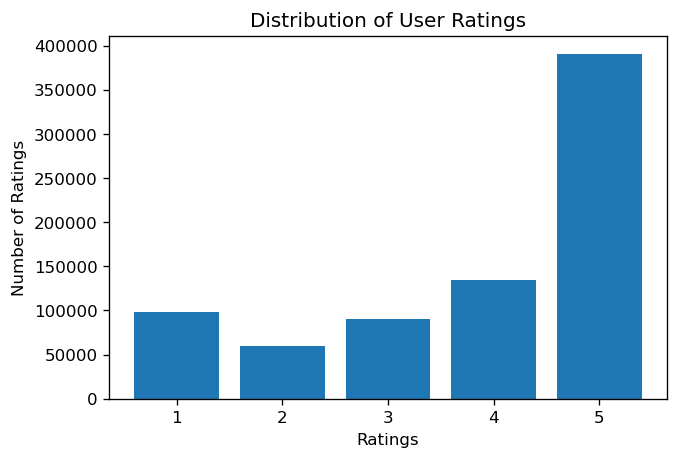

In [201]:
rating = pd.Series(data["rating"].value_counts()).sort_index()

plt.bar(rating.index, rating.values)
plt.xlabel("Ratings")
plt.ylabel("Number of Ratings")
plt.title("Distribution of User Ratings")

In [202]:
# Extract review features for importance ranking
import readability
from textblob import TextBlob

data_tmp = data.copy() # Whole dataset

feature = pd.DataFrame()
feature["rating"] = data_tmp["rating"]
feature["vote"]  = data_tmp["vote"]
feature["length"] = data_tmp["Token_Count"]
feature["prop_of_noun"] = data_tmp["nouns"].str.len() / feature["length"]
feature["prop_of_verb"] = data_tmp["verbs"].str.len() / feature["length"]
feature["prop_of_adj_adverb"] = (data_tmp["adjs"].str.len() + data_tmp["adverbs"].str.len()) / feature["length"]
feature["subjectivity"] = data_tmp["clean"].apply(lambda x: TextBlob(x).sentiment.subjectivity)
feature["readability"] = data_tmp["reviewText"].apply(lambda x: readability.getmeasures(x, lang='en')['readability grades']['FleschReadingEase'])
feature

,rating,vote,length,prop_of_noun,prop_of_verb,prop_of_adj_adverb,subjectivity,readability
0,5.0,0.0,3.0,0.333333,0.333333,0.333333,0.250000,97.025000
1,2.0,3.0,23.0,0.260870,0.347826,0.260870,0.428000,65.530000
2,4.0,0.0,27.0,0.333333,0.259259,0.185185,0.375000,57.153696
5,5.0,0.0,3.0,0.000000,0.333333,0.666667,0.250000,97.025000
6,4.0,0.0,18.0,0.388889,0.277778,0.222222,0.503846,69.814231
...,...,...,...,...,...,...,...,...
881895,5.0,0.0,24.0,0.250000,0.166667,0.416667,0.575397,79.406122
881896,5.0,2.0,23.0,0.347826,0.173913,0.478261,0.561896,85.865000
881897,3.0,0.0,4.0,0.250000,0.000000,0.750000,0.100000,116.145000
881898,3.0,0.0,5.0,0.200000,0.200000,0.600000,0.191667,115.130000


In [203]:
feature.corr() # No strong correlation feature pair existed

,rating,vote,length,prop_of_noun,prop_of_verb,prop_of_adj_adverb,subjectivity,readability
rating,1.000000,-0.006585,-0.006939,0.029987,-0.035307,0.027592,0.266923,-0.047237
vote,-0.006585,1.000000,0.175277,0.001166,0.021801,-0.021222,-0.011888,-0.103001
length,-0.006939,0.175277,1.000000,-0.027827,0.105354,-0.096932,-0.058151,-0.599194
prop_of_noun,0.029987,0.001166,-0.027827,1.000000,-0.371952,-0.417832,0.000084,-0.004574
prop_of_verb,-0.035307,0.021801,0.105354,-0.371952,1.000000,-0.436283,-0.142363,-0.025403
prop_of_adj_adverb,0.027592,-0.021222,-0.096932,-0.417832,-0.436283,1.000000,0.170937,-0.069898
subjectivity,0.266923,-0.011888,-0.058151,0.000084,-0.142363,0.170937,1.000000,-0.070202
readability,-0.047237,-0.103001,-0.599194,-0.004574,-0.025403,-0.069898,-0.070202,1.000000


## Feature Importance

In [204]:
# Which feature best reflects user sentiment polarity (user satisfaction)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
                        feature.iloc[:,1:].to_numpy(), data_tmp["rating"].to_numpy().reshape(-1), test_size=0.2, random_state=42)

In [205]:
# # Grid Search CV to find the best set of params
# grid = { 
#     'n_estimators': [200,300,400,500],
#     'max_features': ['sqrt','log2'],
#     'max_depth' : [3,4,5,6,7],
#     'random_state' : [18]
# }

# ## Grid Search function
# CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5)
# CV_rfr.fit(X_train, y_train)

In [206]:
# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n",CV_rfr.best_estimator_)
# print("\n The best score across ALL searched params:\n",CV_rfr.best_score_)
# print("\n The best parameters across ALL searched params:\n",CV_rfr.best_params_)

In [207]:
rf = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 7, random_state = 18).fit(X_train, y_train)

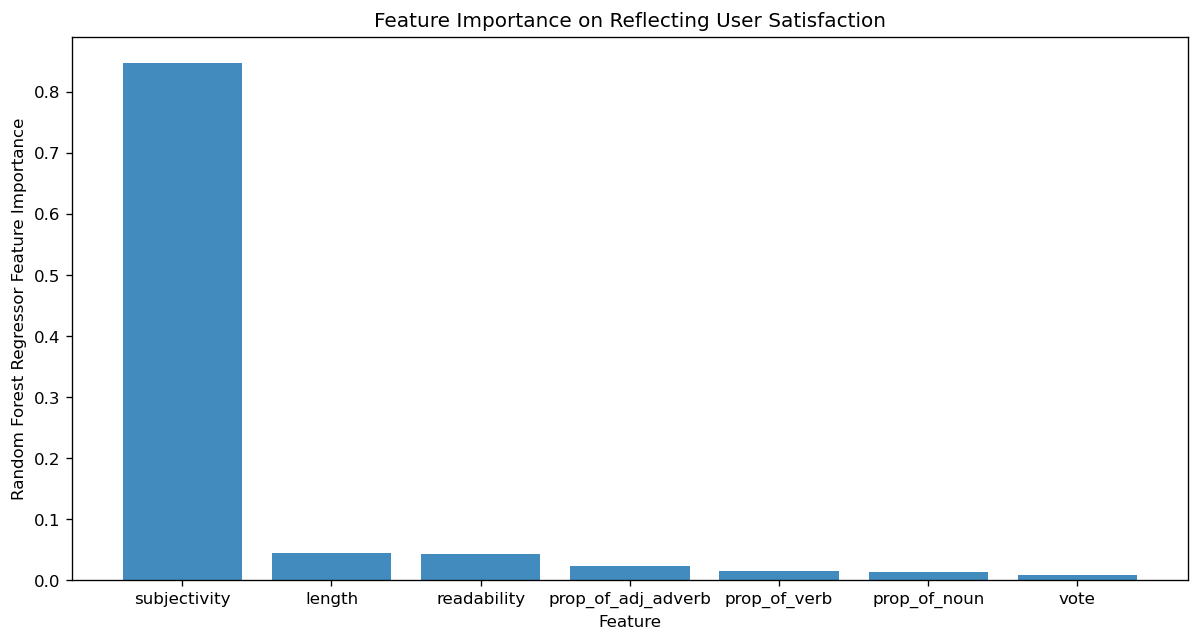

In [208]:
# Visualizations of Feature Importance
feature_name = feature.columns.values[1:][np.argsort(rf.feature_importances_)][::-1]
feature_importance = np.sort(rf.feature_importances_)[::-1]

fig = plt.figure(figsize=(12, 6))
plt.bar(feature_name, feature_importance, alpha=0.85)
plt.title("Feature Importance on Reflecting User Satisfaction")
plt.xlabel("Feature")
plt.ylabel("Random Forest Regressor Feature Importance")
plt.show()

It is observed that subjectivity has the highest feature importance on reflecting user satisfaction, followed by length, readability, proportion of adjs & adverbs. This indicated that in the fashion category, users with higher product satisfaction tended to give more subjective comments on the product, using higher portion of adjs and adverbs to highlight their feelings and satisfaction towards the product. Besides, users with higher satisfaction tended to write a longer review to document their experience in detail with higher corresponding text readability.

In [209]:
# Which features best influences review helpfulness
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
                                                        feature[["rating"] + list(feature.columns)[2:]].to_numpy(), data_tmp["vote"].to_numpy().reshape(-1), 
                                                        test_size=0.2, random_state=42)

In [210]:
# # The grid search CV was costing too much time and will be ran later. For the code below, an initial set of params were used.
# grid_vote = { 
#     'n_estimators': [200,300,400,500],
#     'max_features': ['sqrt','log2'],
#     'max_depth' : [3,4,5,6,7],
#     'random_state' : [18]
# }

# ## Grid Search function
# CV_rfr_vote = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid_vote, cv= 5)
# CV_rfr_vote.fit(X_train, y_train)

In [211]:
# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n",CV_rfr_vote.best_estimator_)
# print("\n The best score across ALL searched params:\n",CV_rfr_vote.best_score_)
# print("\n The best parameters across ALL searched params:\n",CV_rfr_vote.best_params_)

In [212]:
rf_vote = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18).fit(X_train, y_train)

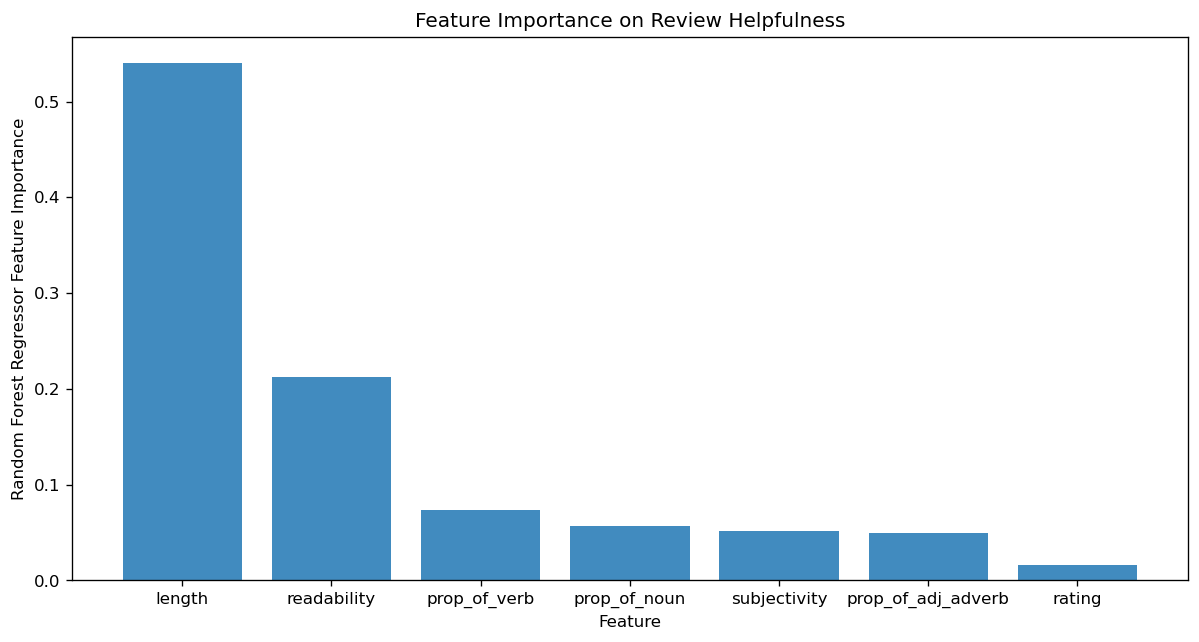

In [213]:
# Visualizations of Feature Importance
feature_name = np.array(["rating"] + list(feature.columns)[2:])[np.argsort(rf_vote.feature_importances_)][::-1]
feature_importance = np.sort(rf_vote.feature_importances_)[::-1]

fig = plt.figure(figsize=(12, 6))
plt.bar(feature_name, feature_importance, alpha=0.85)
plt.title("Feature Importance on Review Helpfulness")
plt.xlabel("Feature")
plt.ylabel("Random Forest Regressor Feature Importance")
plt.show()

Length is the most important feature that impacts review helpfulness, followed by readability, proportion of verbs and nouns. This implied that long reviews with good readability had higher probability to be endorsed by readers since they provided more information on the product. The proportion of nouns might be correlated to the proportion of product-related feature terms mentioned in the reviews. A higher proportion of product-related feature terms indicated that more product features were discussed and evaluated in the reviews, thus providing readers with more relevant information on the product.

## Data Visualizations

In [214]:
# Aggregate current data for visualizations

feature_visual = pd.concat([data_tmp[["reviewTime","day_gap","year-month","year"]], feature], axis=1).reset_index(drop=True)
feature_visual

,reviewTime,day_gap,year-month,year,rating,vote,length,prop_of_noun,prop_of_verb,prop_of_adj_adverb,subjectivity,readability
0,2014-10-20,1442,2014-10,2014,5.0,0.0,3.0,0.333333,0.333333,0.333333,0.250000,97.025000
1,2014-09-28,1464,2014-09,2014,2.0,3.0,23.0,0.260870,0.347826,0.260870,0.428000,65.530000
2,2014-08-25,1498,2014-08,2014,4.0,0.0,27.0,0.333333,0.259259,0.185185,0.375000,57.153696
3,2014-07-19,1535,2014-07,2014,5.0,0.0,3.0,0.000000,0.333333,0.666667,0.250000,97.025000
4,2014-05-31,1584,2014-05,2014,4.0,0.0,18.0,0.388889,0.277778,0.222222,0.503846,69.814231
...,...,...,...,...,...,...,...,...,...,...,...,...
772846,2017-02-21,587,2017-02,2017,5.0,0.0,24.0,0.250000,0.166667,0.416667,0.575397,79.406122
772847,2016-11-25,675,2016-11,2016,5.0,2.0,23.0,0.347826,0.173913,0.478261,0.561896,85.865000
772848,2016-11-10,690,2016-11,2016,3.0,0.0,4.0,0.250000,0.000000,0.750000,0.100000,116.145000
772849,2016-11-10,690,2016-11,2016,3.0,0.0,5.0,0.200000,0.200000,0.600000,0.191667,115.130000


In [215]:
# Correlation analysis

feature_visual.corr()

,day_gap,rating,vote,length,prop_of_noun,prop_of_verb,prop_of_adj_adverb,subjectivity,readability
day_gap,1.000000,0.003453,0.079949,0.126429,-0.011352,0.035403,-0.043770,-0.002551,-0.085476
rating,0.003453,1.000000,-0.006585,-0.006939,0.029987,-0.035307,0.027592,0.266923,-0.047237
vote,0.079949,-0.006585,1.000000,0.175277,0.001166,0.021801,-0.021222,-0.011888,-0.103001
length,0.126429,-0.006939,0.175277,1.000000,-0.027827,0.105354,-0.096932,-0.058151,-0.599194
prop_of_noun,-0.011352,0.029987,0.001166,-0.027827,1.000000,-0.371952,-0.417832,0.000084,-0.004574
prop_of_verb,0.035403,-0.035307,0.021801,0.105354,-0.371952,1.000000,-0.436283,-0.142363,-0.025403
prop_of_adj_adverb,-0.043770,0.027592,-0.021222,-0.096932,-0.417832,-0.436283,1.000000,0.170937,-0.069898
subjectivity,-0.002551,0.266923,-0.011888,-0.058151,0.000084,-0.142363,0.170937,1.000000,-0.070202
readability,-0.085476,-0.047237,-0.103001,-0.599194,-0.004574,-0.025403,-0.069898,-0.070202,1.000000


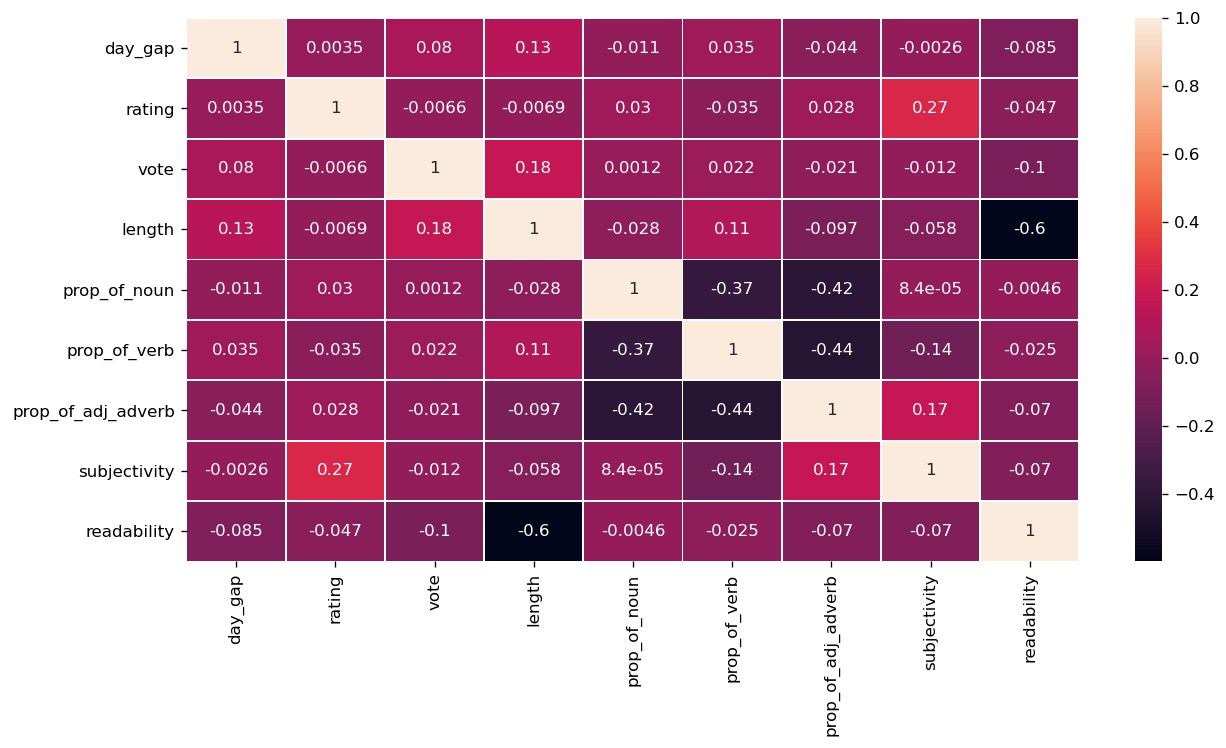

In [216]:
fig = plt.figure(figsize=(12, 6))
sns.heatmap(feature_visual.corr(), annot=True, linewidth=.5)

There exists a relatively strong opposing correlation between length and readability (long reviews are harder to read) and among prop of pos, which is reasonable. No other strong correlation pairs existed.

In [217]:
# Trend Analysis

# Aggregate the features by year, taking mean as the aggregation method.
trend_data_by_year = feature_visual.iloc[:, 3:].groupby("year").mean().reset_index()
trend_data_by_year

,year,rating,vote,length,prop_of_noun,prop_of_verb,prop_of_adj_adverb,subjectivity,readability
0,2002,4.200000,13.800000,85.800000,0.425157,0.152183,0.274587,0.516109,31.918511
1,2003,4.263158,2.368421,36.684211,0.334490,0.217746,0.300683,0.571253,71.498058
2,2004,3.884615,4.365385,55.596154,0.377105,0.208126,0.294887,0.528821,34.518835
3,2005,3.584416,4.558442,47.051948,0.353878,0.220581,0.272577,0.538366,46.234204
4,2006,4.051672,3.650456,38.559271,0.357404,0.215673,0.287133,0.555400,52.933711
5,2007,4.086604,1.771313,31.715156,0.361859,0.215102,0.281576,0.564990,58.975530
6,2008,4.134320,2.233553,32.861294,0.360240,0.217832,0.278448,0.578377,56.199240
7,2009,4.155734,3.026899,36.654082,0.354649,0.222238,0.281769,0.566500,54.499226
8,2010,4.107822,2.506554,38.073573,0.359674,0.223288,0.278546,0.547308,50.210647
9,2011,4.032873,2.017317,36.897564,0.357526,0.222387,0.278454,0.551204,51.975263


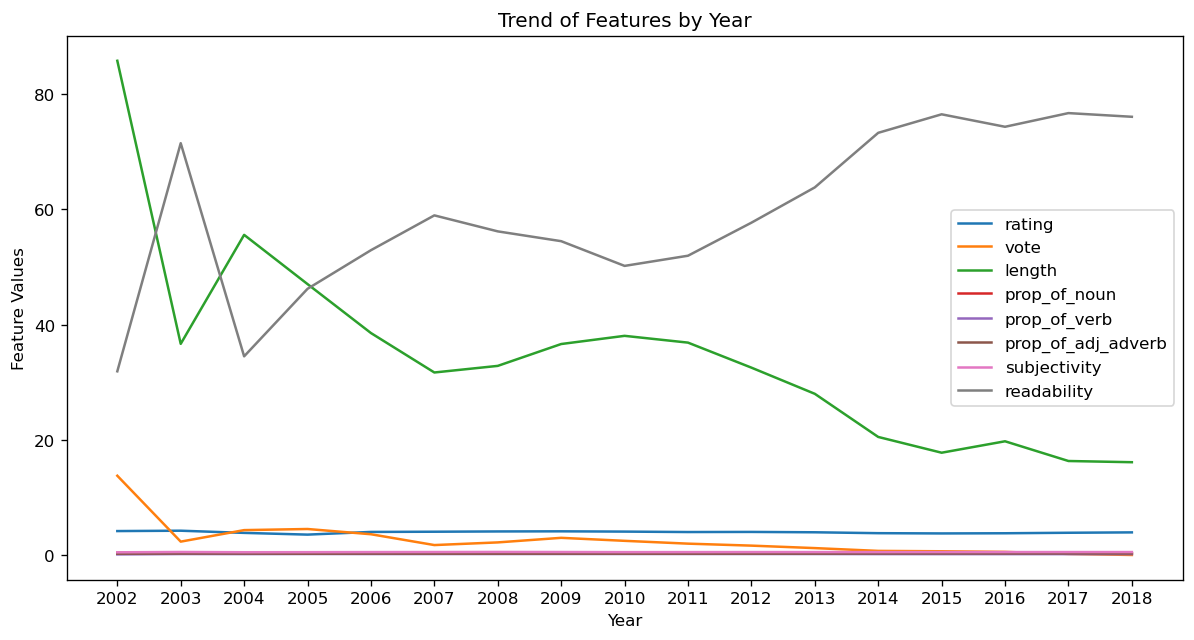

In [218]:
fig = plt.figure(figsize=(12, 6))
plt.plot(trend_data_by_year["year"], trend_data_by_year["rating"], label = "rating")
plt.plot(trend_data_by_year["year"], trend_data_by_year["vote"], label = "vote")
plt.plot(trend_data_by_year["year"], trend_data_by_year["length"], label = "length")
plt.plot(trend_data_by_year["year"], trend_data_by_year["prop_of_noun"], label = "prop_of_noun")
plt.plot(trend_data_by_year["year"], trend_data_by_year["prop_of_verb"], label = "prop_of_verb")
plt.plot(trend_data_by_year["year"], trend_data_by_year["prop_of_adj_adverb"], label = "prop_of_adj_adverb")
plt.plot(trend_data_by_year["year"], trend_data_by_year["subjectivity"], label = "subjectivity")
plt.plot(trend_data_by_year["year"], trend_data_by_year["readability"], label = "readability")
plt.xlabel("Year")
plt.ylabel("Feature Values")
plt.title("Trend of Features by Year")
plt.legend()

[Text(0, 0.5, 'Feature Values'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Trend of readability by year')]

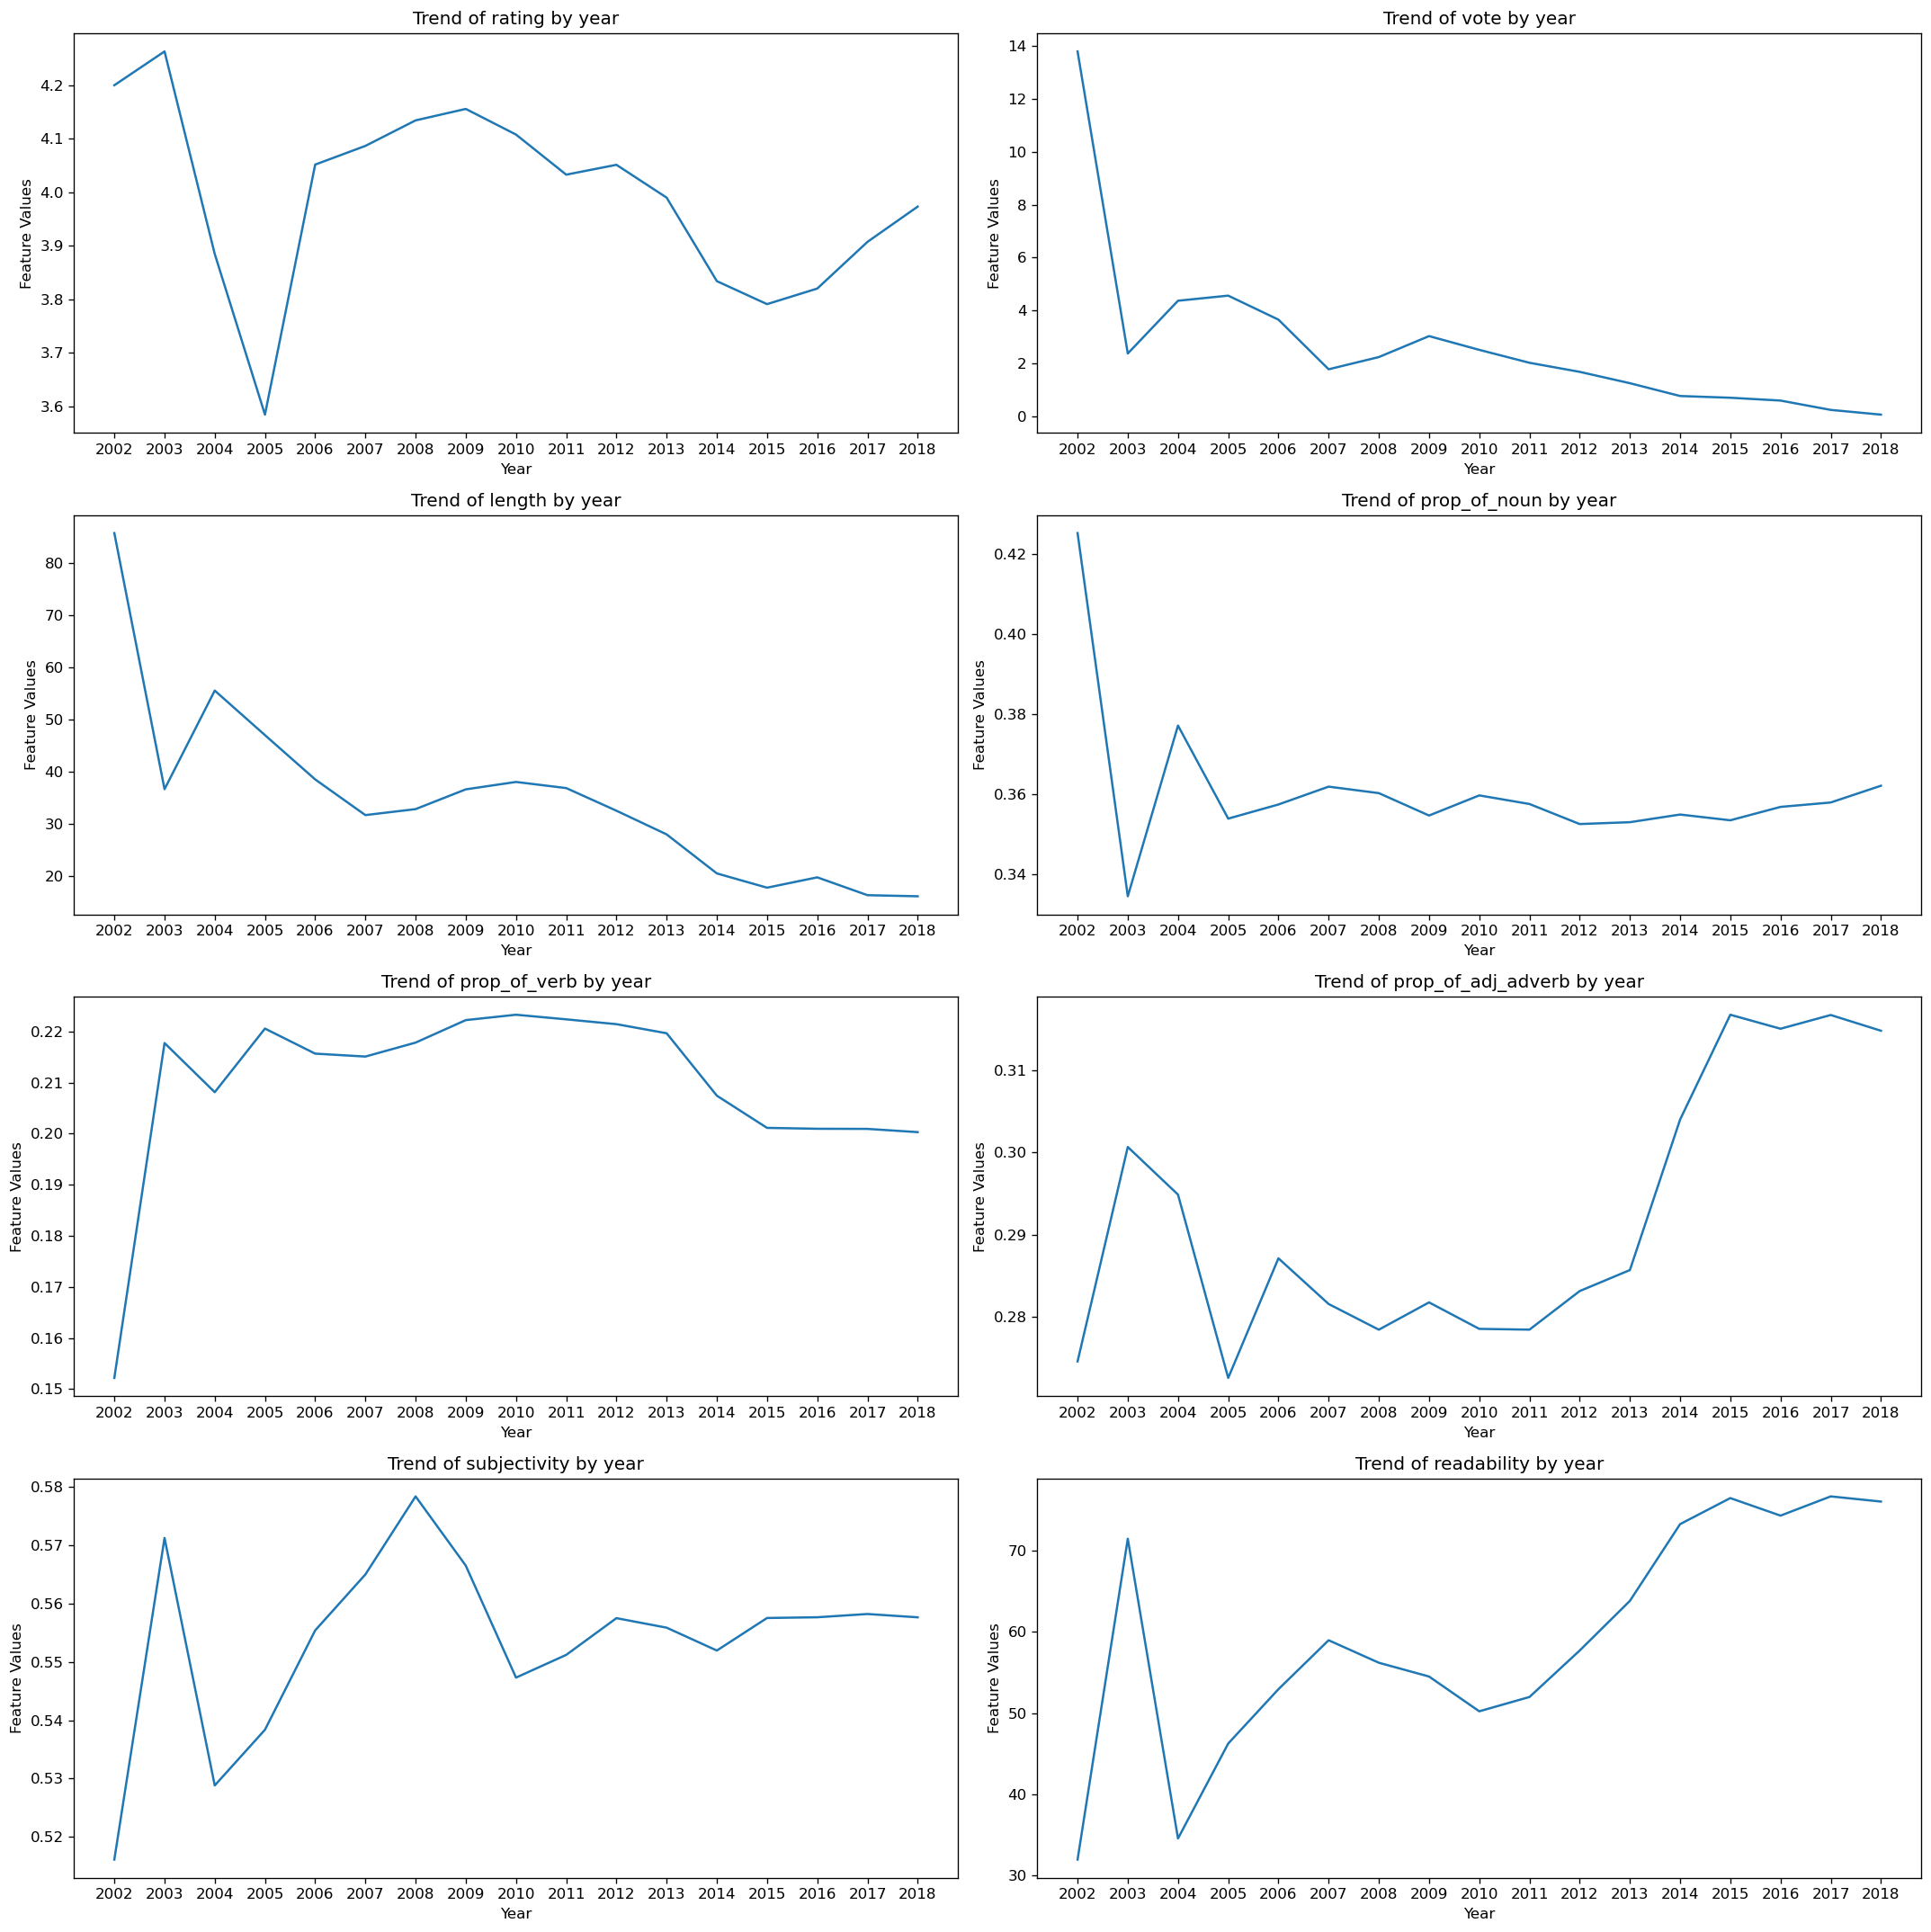

In [219]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize=(18, 18), tight_layout=True)
axes[0][0].plot(trend_data_by_year["year"], trend_data_by_year["rating"], label = "rating")
axes[0][0].set(title="Trend of rating by year", xlabel="Year", ylabel="Feature Values")
axes[0][1].plot(trend_data_by_year["year"], trend_data_by_year["vote"], label = "vote")
axes[0][1].set(title="Trend of vote by year", xlabel="Year", ylabel="Feature Values")
axes[1][0].plot(trend_data_by_year["year"], trend_data_by_year["length"], label = "length")
axes[1][0].set(title="Trend of length by year", xlabel="Year", ylabel="Feature Values")
axes[1][1].plot(trend_data_by_year["year"], trend_data_by_year["prop_of_noun"], label = "prop_of_noun")
axes[1][1].set(title="Trend of prop_of_noun by year", xlabel="Year", ylabel="Feature Values")
axes[2][0].plot(trend_data_by_year["year"], trend_data_by_year["prop_of_verb"], label = "prop_of_verb")
axes[2][0].set(title="Trend of prop_of_verb by year", xlabel="Year", ylabel="Feature Values")
axes[2][1].plot(trend_data_by_year["year"], trend_data_by_year["prop_of_adj_adverb"], label = "prop_of_adj_adverb")
axes[2][1].set(title="Trend of prop_of_adj_adverb by year", xlabel="Year", ylabel="Feature Values")
axes[3][0].plot(trend_data_by_year["year"], trend_data_by_year["subjectivity"], label = "subjectivity")
axes[3][0].set(title="Trend of subjectivity by year", xlabel="Year", ylabel="Feature Values")
axes[3][1].plot(trend_data_by_year["year"], trend_data_by_year["readability"], label = "readability")
axes[3][1].set(title="Trend of readability by year", xlabel="Year", ylabel="Feature Values")

From the graph, there exist a general decreasing trend in rating, vote, length. Consumers might be more sensitive to product quality and write more succinct reviews. Also, the prop_of_adj_adverb and readability observed an increasing trend. Consumers might be expressing more personal and subjective experiences. With shorter reviews on average, the readability also increased accordingly.

In [220]:
# Aggregate the features by year & month, taking mean as the aggregation method.
trend_data_by_year_month = feature_visual.iloc[:, 2:].groupby("year-month").mean().reset_index()
trend_data_by_year_month

,year-month,rating,vote,length,prop_of_noun,prop_of_verb,prop_of_adj_adverb,subjectivity,readability
0,2002-11,4.000000,22.333333,121.000000,0.426543,0.182413,0.256315,0.496154,22.187515
1,2002-12,4.500000,1.000000,33.000000,0.423077,0.106838,0.301994,0.546042,46.515004
2,2003-01,4.000000,2.000000,36.000000,0.250000,0.277778,0.361111,0.543537,65.048432
3,2003-02,4.000000,2.500000,40.500000,0.454907,0.191976,0.226459,0.518286,58.974375
4,2003-03,4.666667,0.000000,47.333333,0.343834,0.166911,0.318681,0.443439,68.554675
...,...,...,...,...,...,...,...,...,...
183,2018-06,4.025362,0.032799,16.480740,0.364026,0.198231,0.318112,0.564807,74.842845
184,2018-07,3.994136,0.032983,16.104324,0.366495,0.199235,0.312813,0.551134,76.182614
185,2018-08,3.991377,0.035088,15.647636,0.368793,0.197361,0.315151,0.549236,76.385344
186,2018-09,3.973803,0.027100,16.580849,0.367256,0.193542,0.320579,0.552602,73.898460


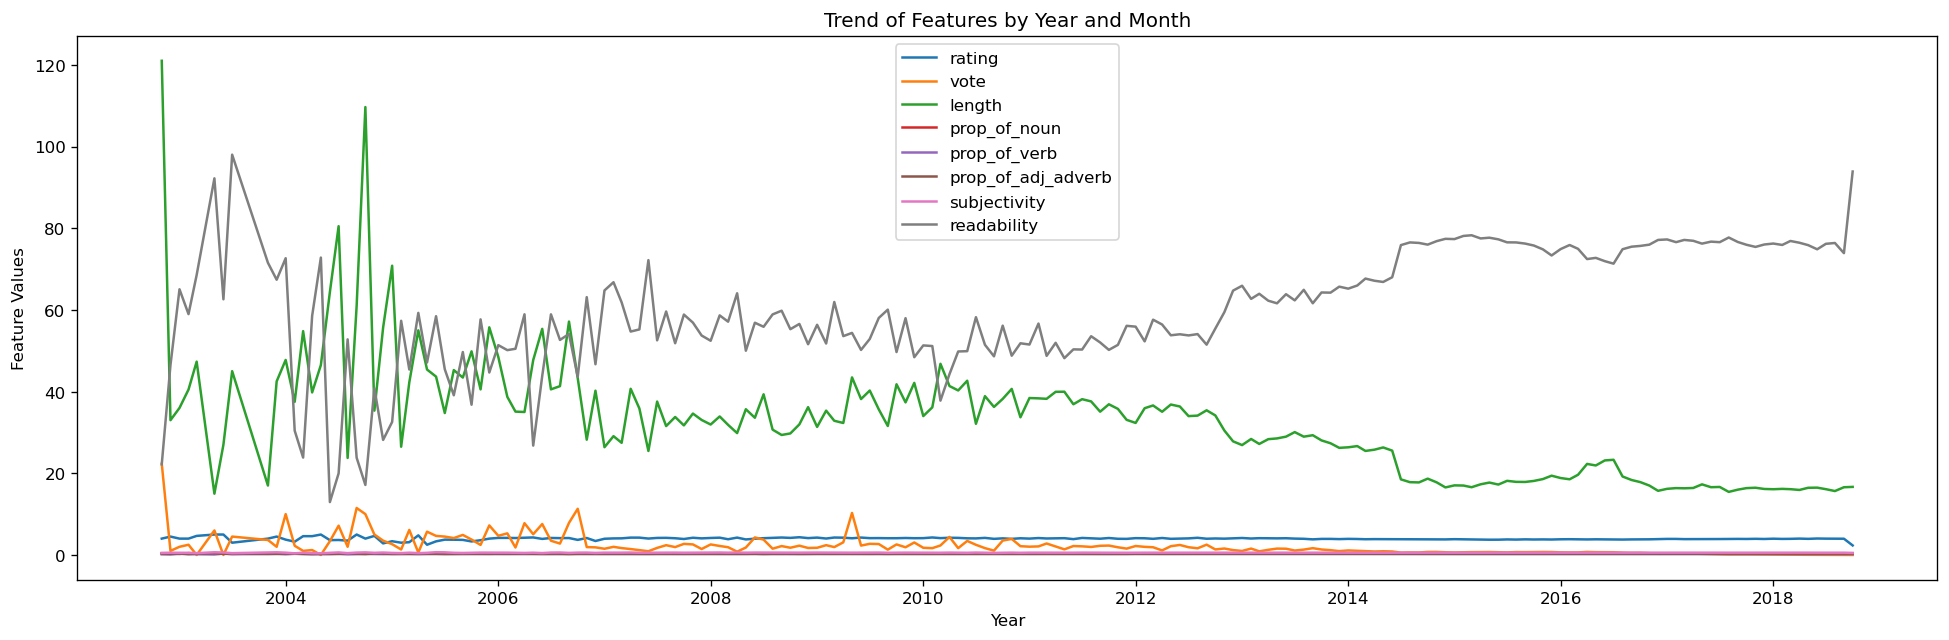

In [221]:
fig = plt.figure(figsize=(20, 6))
year_month = np.asarray(trend_data_by_year_month["year-month"], dtype='datetime64[s]')
plt.plot(year_month, trend_data_by_year_month["rating"], label = "rating")
plt.plot(year_month, trend_data_by_year_month["vote"], label = "vote")
plt.plot(year_month, trend_data_by_year_month["length"], label = "length")
plt.plot(year_month, trend_data_by_year_month["prop_of_noun"], label = "prop_of_noun")
plt.plot(year_month, trend_data_by_year_month["prop_of_verb"], label = "prop_of_verb")
plt.plot(year_month, trend_data_by_year_month["prop_of_adj_adverb"], label = "prop_of_adj_adverb")
plt.plot(year_month, trend_data_by_year_month["subjectivity"], label = "subjectivity")
plt.plot(year_month, trend_data_by_year_month["readability"], label = "readability")
plt.xlabel("Year")
plt.ylabel("Feature Values")
#plt.xticks(rotation = 90)
plt.title("Trend of Features by Year and Month")
plt.legend()

[Text(0, 0.5, 'Feature Values'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Trend of readability by year and month')]

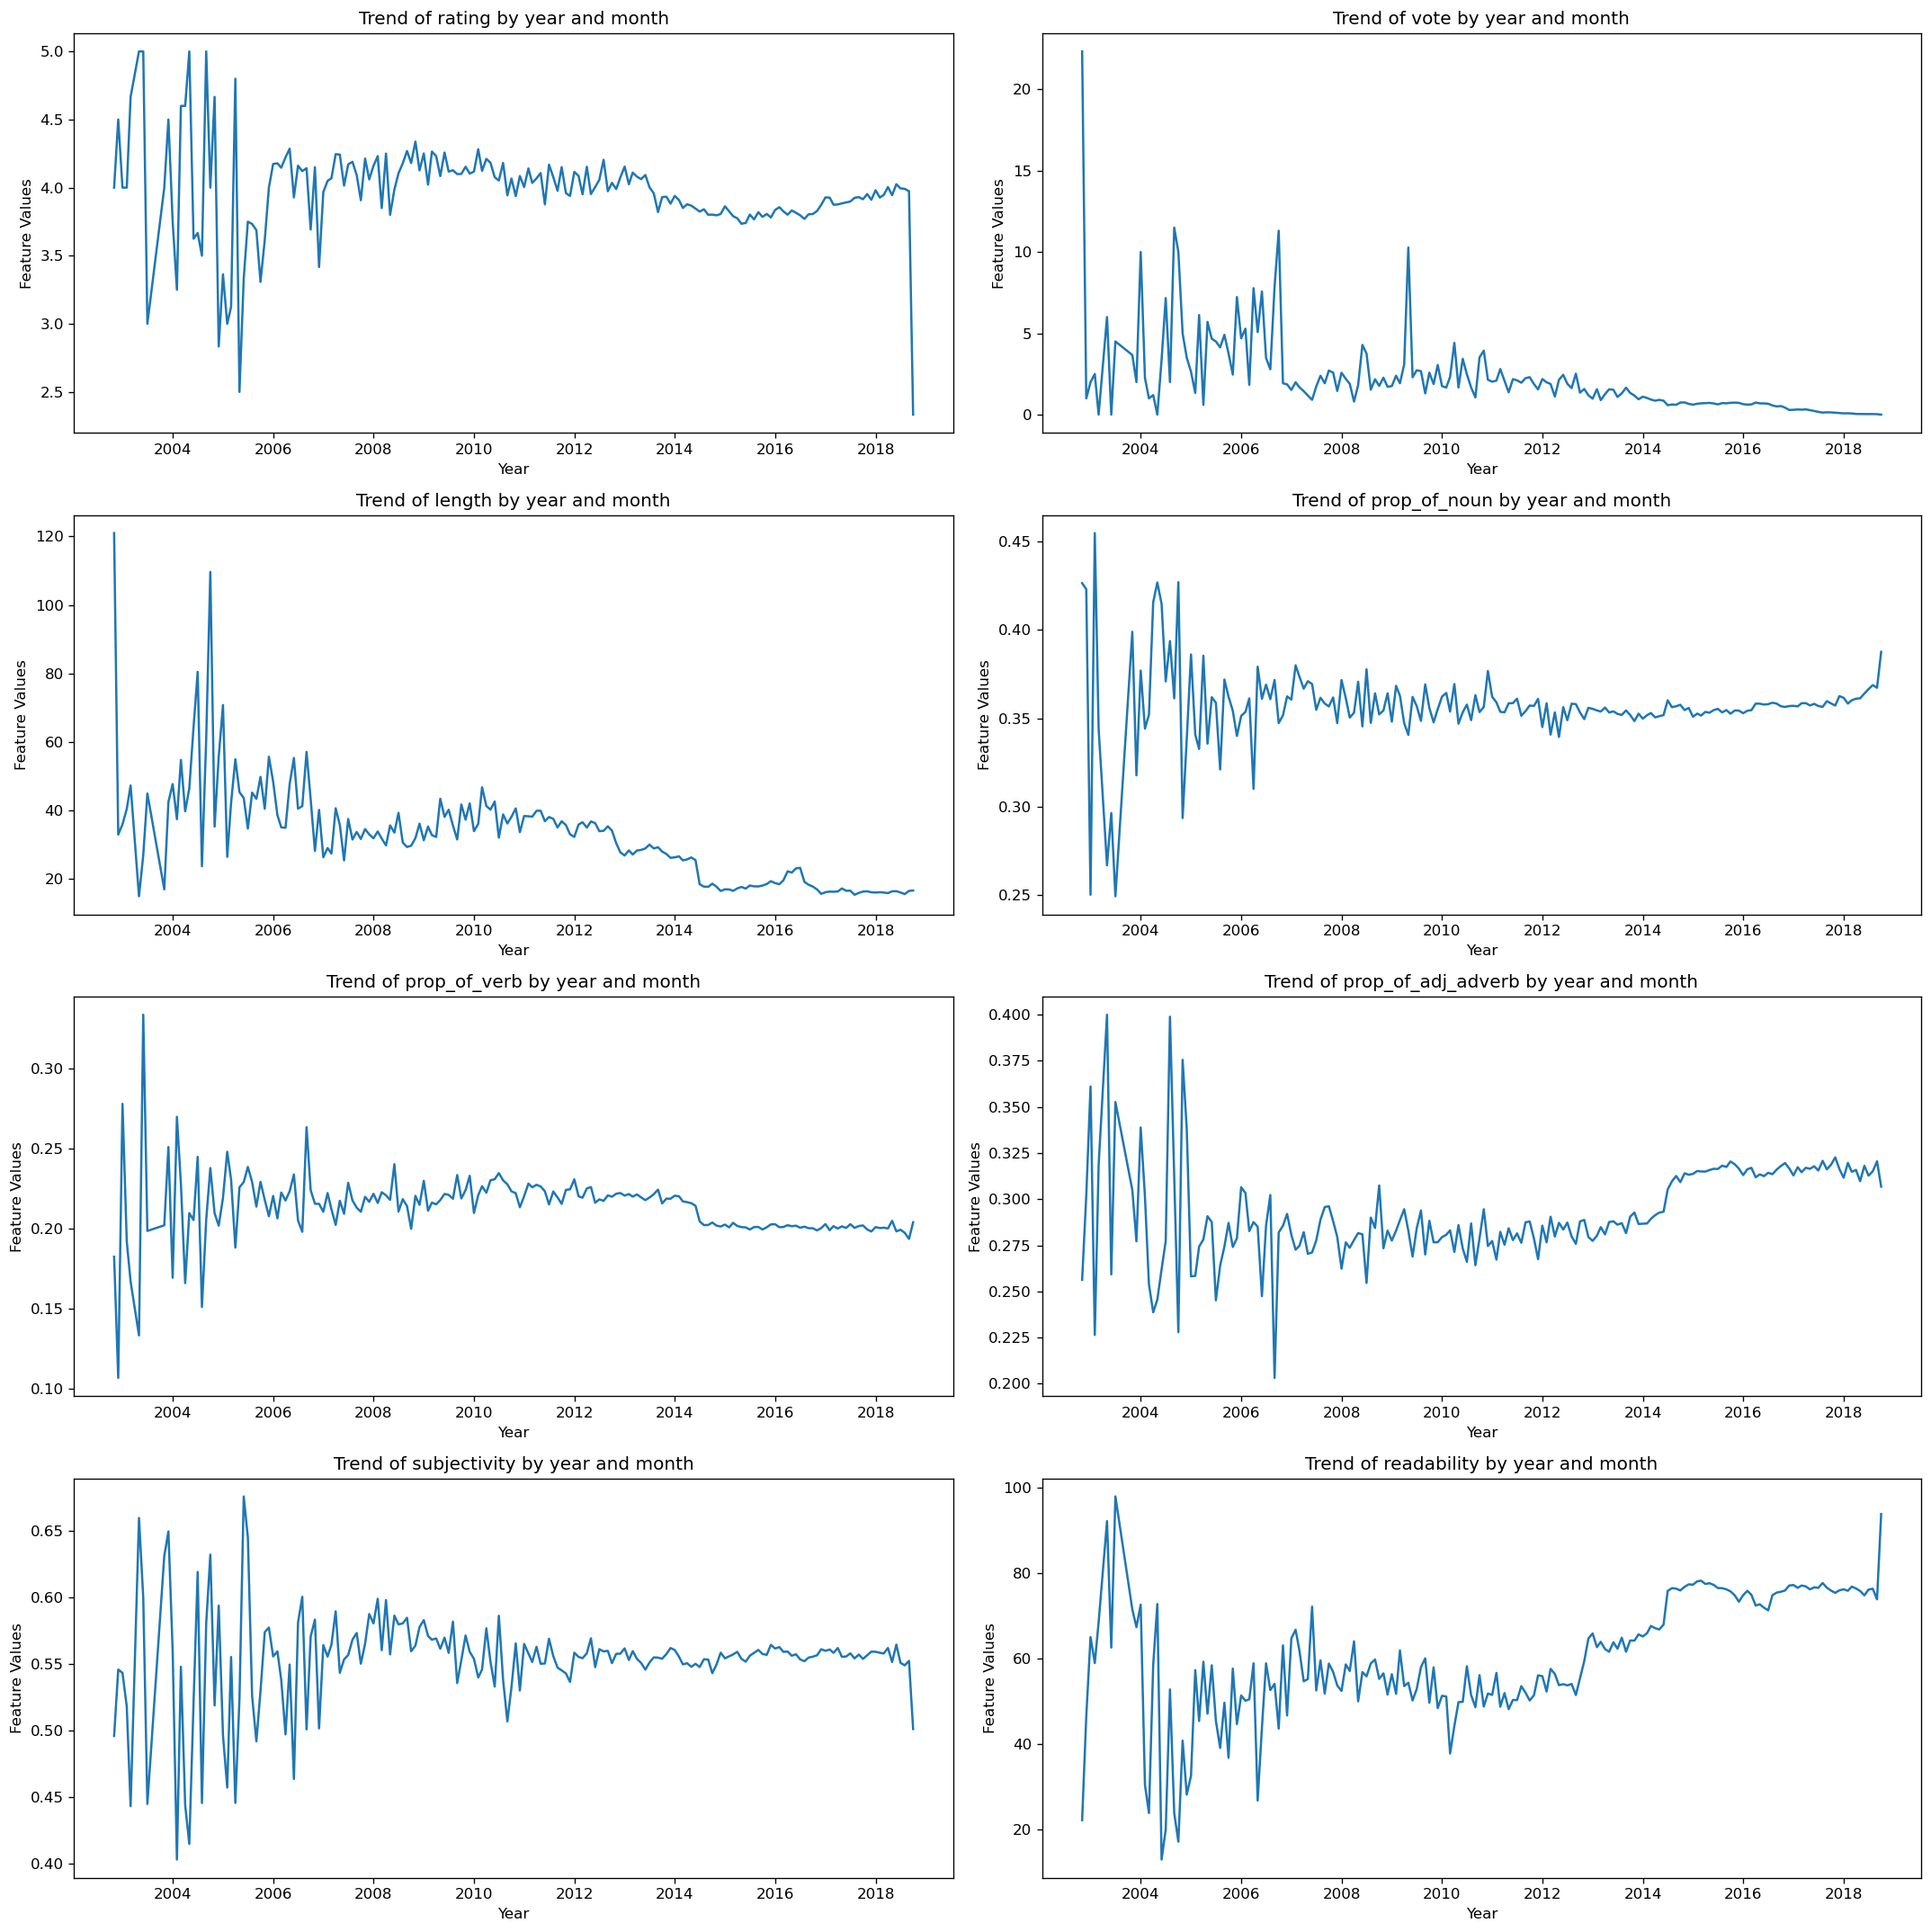

In [222]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize=(18, 18), tight_layout=True)
axes[0][0].plot(year_month, trend_data_by_year_month["rating"], label = "rating")
axes[0][0].set(title="Trend of rating by year and month", xlabel="Year", ylabel="Feature Values")
axes[0][1].plot(year_month, trend_data_by_year_month["vote"], label = "vote")
axes[0][1].set(title="Trend of vote by year and month", xlabel="Year", ylabel="Feature Values")
axes[1][0].plot(year_month, trend_data_by_year_month["length"], label = "length")
axes[1][0].set(title="Trend of length by year and month", xlabel="Year", ylabel="Feature Values")
axes[1][1].plot(year_month, trend_data_by_year_month["prop_of_noun"], label = "prop_of_noun")
axes[1][1].set(title="Trend of prop_of_noun by year and month", xlabel="Year", ylabel="Feature Values")
axes[2][0].plot(year_month, trend_data_by_year_month["prop_of_verb"], label = "prop_of_verb")
axes[2][0].set(title="Trend of prop_of_verb by year and month", xlabel="Year", ylabel="Feature Values")
axes[2][1].plot(year_month, trend_data_by_year_month["prop_of_adj_adverb"], label = "prop_of_adj_adverb")
axes[2][1].set(title="Trend of prop_of_adj_adverb by year and month", xlabel="Year", ylabel="Feature Values")
axes[3][0].plot(year_month, trend_data_by_year_month["subjectivity"], label = "subjectivity")
axes[3][0].set(title="Trend of subjectivity by year and month", xlabel="Year", ylabel="Feature Values")
axes[3][1].plot(year_month, trend_data_by_year_month["readability"], label = "readability")
axes[3][1].set(title="Trend of readability by year and month", xlabel="Year", ylabel="Feature Values")

### Trend of Keywords

In [223]:
# Dataset Construction
data_visual = data.copy()
data_visual.index = pd.to_datetime(data_visual.reviewTime)
data_visual = data_visual[["tagged_filtered","tokenized_filtered", "bigram", "rating", "vote", "sentiment"]]
data_visual = data_visual[data_visual.index>="2013"] # To ensure the trend validity, only the years with reviews>10k are considered.
data_visual.head(10)

,tagged_filtered,tokenized_filtered,bigram,rating,vote,sentiment
reviewTime,,,,,,
2014-10-20,"[exactly, needed]","[exactly, need]",[exactly need],5.0,0.0,positive
2014-09-28,"[agree, review, opening, small, hook, expensive, earrings, trying, get, higher, end, seen, buy, price, sending]","[agree, review, open, small, hook, expensive, earrings, try, get, high, end, see, buy, price, send]","[agree review, review open, open small, small almost, almost bend, bend hook, hook expensive, expensive earrings, earrings try, try get, get high, high end, end they, they see, see would, would bu...",2.0,3.0,negative
2014-08-25,"[going, order, pack, keep, work, someone, including, losing, earring, understand, hook, earrings, wish, tiny, bit]","[go, order, pack, keep, work, someone, include, lose, earring, understand, hook, earrings, wish, tiny, bite]","[love these, these order, order another, another pack, pack keep, keep work, work someone, someone include, include myself, myself always, always lose, lose back, back earring, earring understand,...",4.0,0.0,positive
2014-07-19,"[exactly, wanted]","[exactly, want]",[exactly want],5.0,0.0,positive
2014-05-31,"[little, plastic, backs, work, great, loosing, hook, earrings, wish, ordered, sooner, lost, favorite, earrings]","[little, plastic, back, work, great, loose, hook, earrings, wish, order, sooner, lose, favorite, earrings]","[these little, little plastic, plastic back, back work, work great, great loose, loose hook, hook earrings, earrings wish, wish order, order sooner, sooner lose, lose favorite, favorite earrings, ...",4.0,0.0,positive
2013-09-22,"[mother, law, wanted, sister, liked, said, work]","[mother, law, want, sister, like, say, work]","[mother law, law want, want present, present sister, sister like, like say, say would, would work, mother law want, law want present, want present sister, present sister like, sister like say, lik...",3.0,0.0,neutral
2013-07-17,"[item, good, quality, looks, great, fit, fit, carefully, bottom, case, fingers, shove, pack, level, case, stretching, case, closed, month, buxton, usually, good, quality, product]","[item, good, quality, look, great, fit, fit, carefully, bottom, case, finger, shove, pack, level, case, stretch, case, close, month, buxton, usually, good, quality, product]","[item good, good quality, quality look, look great, great too, too but, but fit, fit but, but stretch, stretch fit, fit carefully, carefully push, push bottom, bottom case, case finger, finger the...",3.0,0.0,neutral
2013-04-13,"[used, last, cheapo, fake, cigarette, case, years, closed, completely, made, look, falling, time, new, cigarette, cases, kings, size, cigs, easy, days, discovered, thrilled, find, amazon, great, p...","[use, last, cheapo, fake, cigarette, case, years, close, completely, make, look, fall, time, new, cigarette, case, kings, size, cigs, easy, days, discover, thrill, find, amazon, great, price, real...","[use last, last cheapo, cheapo fake, fake leather, leather cigarette, cigarette case, case seven, seven years, years still, still close, close completely, completely plastic, plastic make, make lo...",3.0,0.0,neutral
2013-03-09,"[brand, long, time, count, good, quality, merchandise, held, rips, stitching, problems]","[brand, long, time, count, good, quality, merchandise, hold, rip, stitch, problems]","[this brand, brand around, around long, long time, time count, count good, good quality, quality merchandise, merchandise hold, hold well, well rip, rip stitch, stitch problems, this brand around,...",4.0,0.0,positive


In [224]:
import itertools

def most_common_word_func_tokenized(token_list, n_words=15):
    # Transform review tokens into word frequency distribution dataframe

    fdist = FreqDist(token_list) 
    
    # Synoym topics are counted together
    for keyword in synonym_dic:
        if keyword in fdist:
            fdist[synonym_dic[keyword]] += fdist[keyword]
            del fdist[keyword]
    
    # filter out the target topics which are most prevalant between 2013 and 2018
    fdist_filtered = {}
    for key, value in fdist.items():
        if key in target_keyword_list:
            fdist_filtered[key] = value
    
    n_words = n_words
    
    df_fdist = pd.DataFrame({'Word': fdist_filtered.keys(),
                             'Frequency': fdist_filtered.values()})
    df_fdist = df_fdist.sort_values(by='Frequency', ascending=False).head(n_words)
    
    return df_fdist

def word_dist(df_tmp):
    token_list = df_tmp.iloc[:,0].values
    return most_common_word_func_tokenized(itertools.chain.from_iterable(token_list))

# This is a manually constructed dictionary that matched all similar topics to the same keyword
synonym_dic = {"work great":"great quality", "work perfectly": "great quality", "great product": "great quality", 
                                       "would recommend": "great quality", "work good": "great quality",
                                       "highly recommend": "great quality", "work fine": "great quality", "would recommend": "great quality",
                                       "work well": "great quality", "exactly need": "great quality", "good quality": "great quality",
                                       "good product": "great quality", "great product": "great quality", "great quality":  "great quality",
                                       "love them": "great quality", "look great": "great quality", "well make": "great quality",
                                       "look good": "great quality", "really like": "great quality", "super cute": "great quality", "like picture": "great quality",
                            "fit perfect": "fit perfectly", "perfect fit": "fit perfectly", "fit well": "fit perfectly", "fit great": "fit perfectly", "fit expect": "fit perfectly",
                            "good price": "great price"}

# After the investigations in the code blocks below, these four topics are the most prevalant and popular topics across 2013-2018.
target_keyword_list = ["great quality", "fit perfectly", "great price", "fast ship"]

data_visual["unique_bigram"] = np.array([np.unique(np.array(token)) for token in data_visual["bigram"]])
data_freq_list = data_visual[["bigram"]].groupby(data_visual.index.strftime("%Y")).apply(word_dist)
data_freq_list # DataFrame: Year - keyword - number of reviews containing this keyword

Word  Frequency
reviewTime                            
2013       3  great quality       3874
           1  fit perfectly       2210
           0    great price        596
           2      fast ship         98
2014       3  great quality       9592
           0  fit perfectly       7949
           1    great price       1411
           2      fast ship        470
2015       3  great quality      19138
           1  fit perfectly      15961
           0    great price       2721
           2      fast ship        995
2016       3  great quality      32913
           0  fit perfectly      27533
           2    great price       3947
           1      fast ship       1214
2017       3  great quality      15945
           0  fit perfectly      14381
           1    great price       2152
           2      fast ship        560
2018       3  great quality       5083
           1  fit perfectly       4756
           0    great price        725
           2      fast ship        212

In [225]:
data_count_review = data_visual[["bigram"]].groupby(data_visual.index.strftime("%Y")).apply("count") # Year - # of reviews this year

data_freq_list_all = pd.merge(data_freq_list, data_count_review, left_index=True, right_index=True, how="inner")
data_freq_list_all["keyword_prop"] = data_freq_list_all["Frequency"] / data_freq_list_all["bigram"] # % of reviews containing this keyword
data_freq_list_all.rename(columns={"bigram":"num of reviews"}, inplace=True)
data_freq_list_all.index = [index[0] for index in data_freq_list_all.index]
data_freq_list_all

,Word,Frequency,num of reviews,keyword_prop
2013,great quality,3874,26774,0.144693
2013,fit perfectly,2210,26774,0.082543
2013,great price,596,26774,0.022260
2013,fast ship,98,26774,0.003660
2014,great quality,9592,81475,0.117729
2014,fit perfectly,7949,81475,0.097564
2014,great price,1411,81475,0.017318
2014,fast ship,470,81475,0.005769
2015,great quality,19138,172139,0.111178
2015,fit perfectly,15961,172139,0.092722


In [226]:
# Reorder the dataframe by the # of reviews containing this keyword. We only want to focus on prevalant topics.
word_year_count = data_freq_list_all[["Word","keyword_prop", "Frequency"]].groupby("Word").agg(["count", "mean"])
word_year_count.sort_values(by=("keyword_prop", "count"), ascending=False)

keyword_prop           Frequency              
                     count      mean     count          mean
Word                                                        
fast ship                6  0.004604         6    591.500000
fit perfectly            6  0.094100         6  12131.666667
great price              6  0.016446         6   1925.333333
great quality            6  0.117011         6  14424.166667

In [227]:
# Create a new dataframe for visualization: entries are % of reviews in this year containing this keyword
data_freq_list_transformed = pd.DataFrame()
data_freq_list_transformed["great quality"] = data_freq_list_all[data_freq_list_all.Word == "great quality"]["keyword_prop"]
data_freq_list_transformed["fit perfectly"] = data_freq_list_all[data_freq_list_all.Word == "fit perfectly"]["keyword_prop"]
data_freq_list_transformed["great price"] = data_freq_list_all[data_freq_list_all.Word == "great price"]["keyword_prop"]
data_freq_list_transformed["fast ship"] = data_freq_list_all[data_freq_list_all.Word == "fast ship"]["keyword_prop"]
#data_freq_list_transformed["easy install"] = data_freq_list_all[data_freq_list_all.Word == "easy install"]["keyword_prop"]
data_freq_list_transformed

,great quality,fit perfectly,great price,fast ship
2013,0.144693,0.082543,0.022260,0.003660
2014,0.117729,0.097564,0.017318,0.005769
2015,0.111178,0.092722,0.015807,0.005780
2016,0.120706,0.100975,0.014475,0.004452
2017,0.106593,0.096137,0.014386,0.003744
2018,0.101168,0.094660,0.014430,0.004219


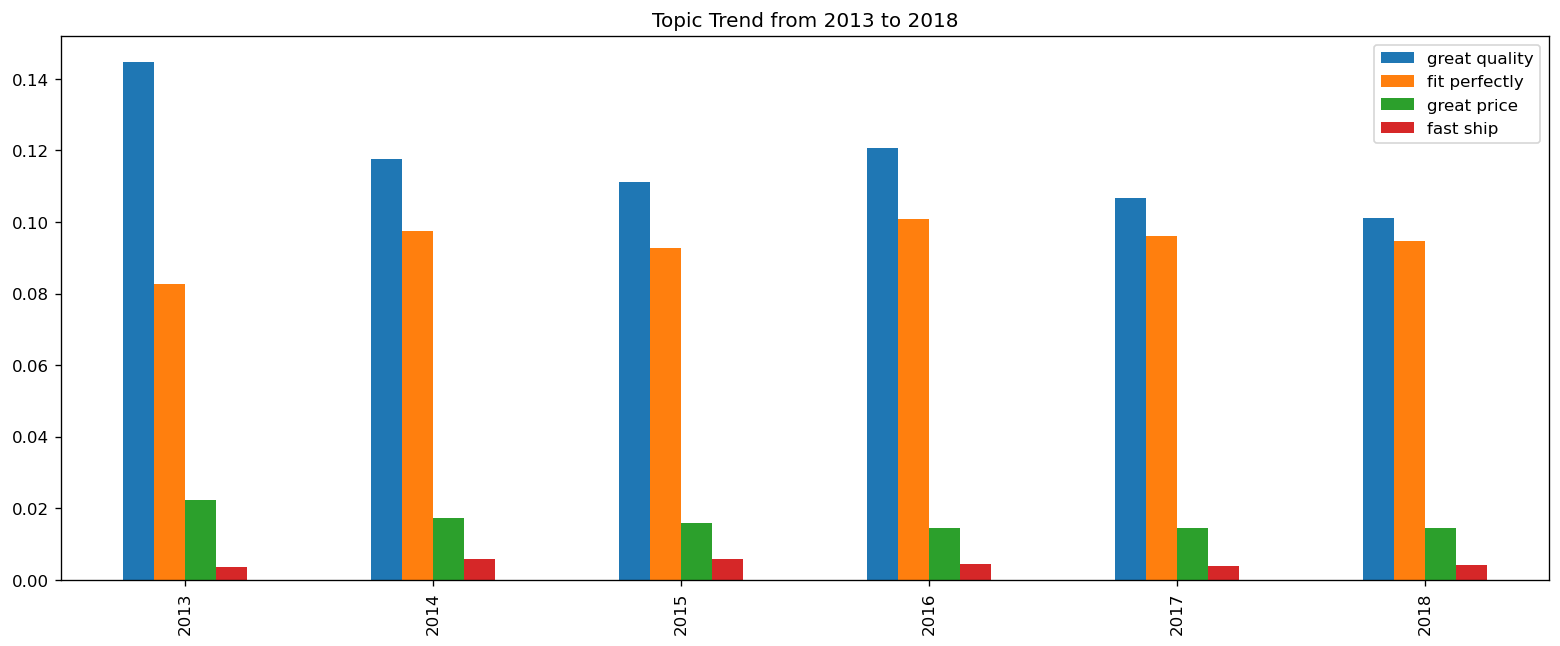

In [228]:
# Trend visualization
plt.rcParams["figure.dpi"] = 120
data_freq_list_transformed.plot(kind="bar", figsize=(16, 6), title="Topic Trend from 2013 to 2018")

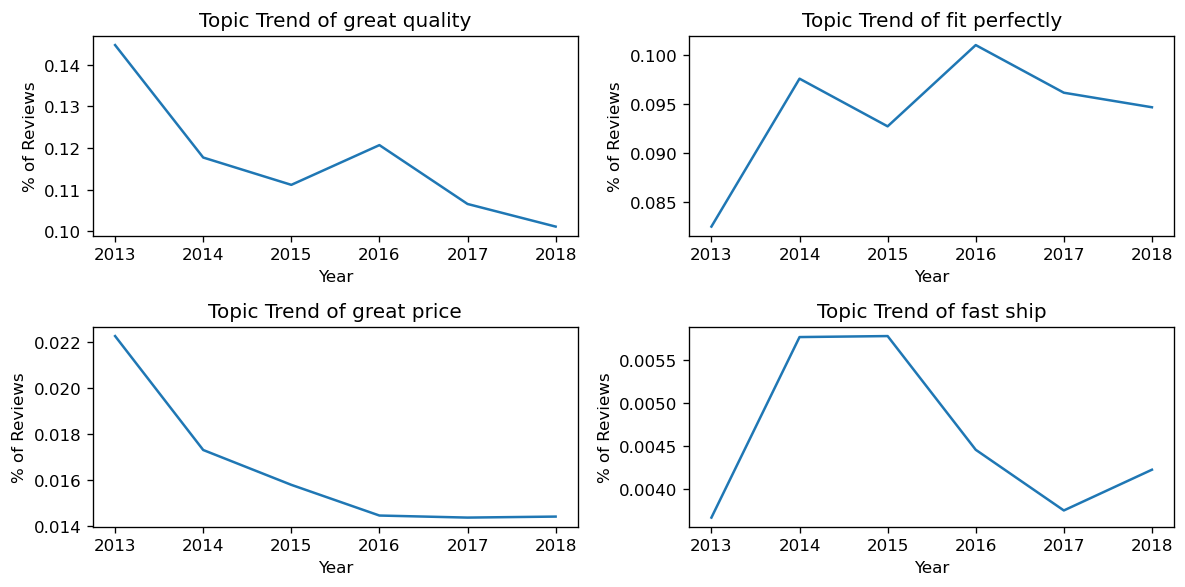

In [229]:
# Trend visualization
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,5), tight_layout=True, dpi=120)
for index in range(len(data_freq_list_transformed.columns)):
    axes[index//2][index%2].plot(data_freq_list_transformed.index, data_freq_list_transformed.iloc[:, index])
    axes[index//2][index%2].set(xlabel="Year", ylabel="% of Reviews", 
                                                       title = "Topic Trend of "+data_freq_list_transformed.columns[index])

### Trend of Customer Satisfaction

In [230]:
# Visualization of the trend of % of positive/neutral/negative reviews across time

data_satisfaction = data_visual[["sentiment", "bigram"]].groupby([data_visual.index.strftime("%Y"), "sentiment"]).count()
data_satisfaction

bigram
reviewTime sentiment        
2013       negative     4503
           neutral      2977
           positive    19294
2014       negative    16395
           neutral     10253
           positive    54827
2015       negative    37374
           neutral     20940
           positive   113825
2016       negative    57969
           neutral     31934
           positive   182768
2017       negative    29313
           neutral     16615
           positive   103660
2018       negative     9299
           neutral      5240
           positive    35704

In [231]:
data_sat_all = pd.merge(data_satisfaction, data_count_review, left_index=True, right_index=True, how="inner")
data_sat_all["% of reviews"] = data_sat_all["bigram_x"] / data_sat_all["bigram_y"] # % of reviews containing this keyword
data_sat_all.rename(columns={"bigram_x":"num of reviews", "bigram_y":"total reviews"}, inplace=True)
data_sat_all.reset_index(inplace=True)
data_sat_all.index = data_sat_all["reviewTime"]
data_sat_all.drop(columns="reviewTime", inplace=True)
data_sat_all

,sentiment,num of reviews,total reviews,% of reviews
reviewTime,,,,
2013,negative,4503,26774,0.168186
2013,neutral,2977,26774,0.111190
2013,positive,19294,26774,0.720624
2014,negative,16395,81475,0.201227
2014,neutral,10253,81475,0.125842
2014,positive,54827,81475,0.672930
2015,negative,37374,172139,0.217115
2015,neutral,20940,172139,0.121646
2015,positive,113825,172139,0.661239


In [232]:
# Create a new dataframe for visualization: entries are % of reviews in this year containing this keyword
data_sat_all_transformed = pd.DataFrame()
data_sat_all_transformed["positive"] = data_sat_all[data_sat_all.sentiment == "positive"]["% of reviews"]
data_sat_all_transformed["neutral"] = data_sat_all[data_sat_all.sentiment == "neutral"]["% of reviews"]
data_sat_all_transformed["negative"] = data_sat_all[data_sat_all.sentiment == "negative"]["% of reviews"]
data_sat_all_transformed

,positive,neutral,negative
reviewTime,,,
2013,0.720624,0.111190,0.168186
2014,0.672930,0.125842,0.201227
2015,0.661239,0.121646,0.217115
2016,0.670288,0.117115,0.212597
2017,0.692970,0.111072,0.195958
2018,0.710626,0.104293,0.185081


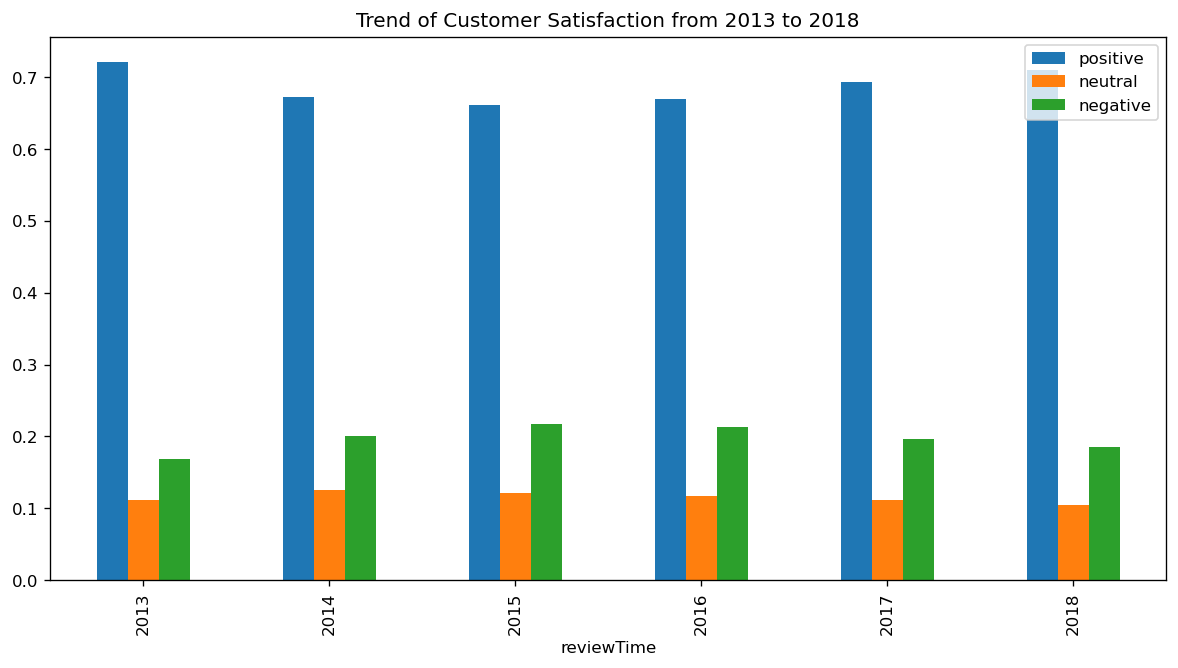

In [233]:
plt.rcParams["figure.dpi"] = 120
data_sat_all_transformed.plot(kind="bar", figsize=(12, 6), title="Trend of Customer Satisfaction from 2013 to 2018")